# üöÄ AI Challenge: Smart Resume-to-Job Matching System

Kjo √´sht√´ nj√´ sfid√´ n√´ 3 faza q√´ do t'ju udh√´heq√´ nga analiza fillestare deri tek nd√´rtimi i nj√´ modeli AI p√´r p√´rputhjen e CV-ve me p√´rshkrimet e pun√´s (JDs).

## üîπ Detyra 1: Analiza dhe P√´rpunimi i t√´ Dh√´nave

***Niveli:*** Fillestar

***Objektivat:***
- Eksploroni datasetin e CV-ve dhe JD-ve
- Pastroni t√´ dh√´nat tekstuale
- Nxirrni karakteristika t√´ thjeshta NLP

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import string
from collections import Counter
import warnings
warnings.filterwarnings('ignore')

# Text processing libraries
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.corpus import wordnet

# ML  libraries
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

# Download required NLTK data
# nltk.download('punkt', quiet=True)
nltk.download('punkt_tab', quiet=True)
nltk.download('stopwords', quiet=True)
nltk.download('wordnet', quiet=True)
nltk.download('averaged_perceptron_tagger_eng', quiet=True)
# nltk.download('averaged_perceptron_tagger', quiet=True)

# Set style for better plots
plt.style.use('default')
sns.set_palette("husl")

In [2]:
# Load the datasets
resume_df = pd.read_csv('Challenge-Data/Resume.csv')
jd_df = pd.read_csv('Challenge-Data/JDs.csv')

print(f"Resume dataset: {resume_df.shape}")
print(f"Job Description dataset: {jd_df.shape}")

Resume dataset: (2484, 4)
Job Description dataset: (853, 5)


In [3]:
resume_df.head()

ID                                         Resume_str  \
0  16852973           HR ADMINISTRATOR/MARKETING ASSOCIATE\...   
1  22323967           HR SPECIALIST, US HR OPERATIONS      ...   
2  33176873           HR DIRECTOR       Summary      Over 2...   
3  27018550           HR SPECIALIST       Summary    Dedica...   
4  17812897           HR MANAGER         Skill Highlights  ...   

                                         Resume_html Category  
0  <div class="fontsize fontface vmargins hmargin...       HR  
1  <div class="fontsize fontface vmargins hmargin...       HR  
2  <div class="fontsize fontface vmargins hmargin...       HR  
3  <div class="fontsize fontface vmargins hmargin...       HR  
4  <div class="fontsize fontface vmargins hmargin...       HR

In [4]:
# Resume dataset overview
print(resume_df.info())
print("\n")
print(f"\nMissing values:")
print(resume_df.isnull().sum())
print("\n")
print(f"\nUnique categories:")
print(resume_df['Category'].value_counts())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2484 entries, 0 to 2483
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   ID           2484 non-null   int64 
 1   Resume_str   2484 non-null   object
 2   Resume_html  2484 non-null   object
 3   Category     2484 non-null   object
dtypes: int64(1), object(3)
memory usage: 77.8+ KB
None



Missing values:
ID             0
Resume_str     0
Resume_html    0
Category       0
dtype: int64



Unique categories:
Category
INFORMATION-TECHNOLOGY    120
BUSINESS-DEVELOPMENT      120
FINANCE                   118
ADVOCATE                  118
ACCOUNTANT                118
ENGINEERING               118
CHEF                      118
AVIATION                  117
FITNESS                   117
SALES                     116
BANKING                   115
HEALTHCARE                115
CONSULTANT                115
CONSTRUCTION              112
PUBLIC-RELATIONS          111
HR         

No missing values for the resume dataset.

In [5]:
jd_df.head()

company_name                                    job_description  \
0       Google  minimum qualifications\nbachelors degree or eq...   
1        Apple  description\nas an asc you will be highly infl...   
2      Netflix  its an amazing time to be joining netflix as w...   
3  Robert Half  description\n\nweb designers looking to expand...   
4    TrackFive  at trackfive weve got big goals were on a miss...   

                              position_title  description_length  \
0                           Sales Specialist                2727   
1                 Apple Solutions Consultant                 828   
2  Licensing Coordinator - Consumer Products                3205   
3                               Web Designer                2489   
4                              Web Developer                3167   

                                      model_response  
0   {\n  "Core Responsibilities": "Responsible fo...  
1   {\n  "Core Responsibilities": "as an asc you ...  
2   {\n  "Core Responsibilities": "Help drive bus...  
3   {\n  "Core Responsibilities": "Designing webs...  
4   {\n  "Core Responsibilities": "Build and layo...

In [6]:
# JD dataset overview
print(jd_df.info())
print("\n")
print(f"\nMissing values:")
print(jd_df.isnull().sum())
print("\n")
print(f"\nUnique categories:")
print(jd_df['description_length'].describe())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 853 entries, 0 to 852
Data columns (total 5 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   company_name        853 non-null    object
 1   job_description     853 non-null    object
 2   position_title      853 non-null    object
 3   description_length  853 non-null    int64 
 4   model_response      853 non-null    object
dtypes: int64(1), object(4)
memory usage: 33.4+ KB
None



Missing values:
company_name          0
job_description       0
position_title        0
description_length    0
model_response        0
dtype: int64



Unique categories:
count      853.000000
mean      3335.600234
std       2094.794724
min         14.000000
25%       1961.000000
50%       3078.000000
75%       4404.000000
max      23924.000000
Name: description_length, dtype: float64


Again, no missing values here neither.

In [7]:
# Statistical analysis of CV and JD categories

# Resume categories analysis
resume_category_counts = resume_df['Category'].value_counts()
print("Resume categories distribution:")
print(resume_category_counts)

# Job description companies analysis
jd_company_counts = jd_df['company_name'].value_counts()
print(f"\nTop 10 companies by number of job postings:")
print(jd_company_counts.head(10))

# Position titles analysis
jd_position_counts = jd_df['position_title'].value_counts()
print(f"\nTop 10 most common position titles:")
print(jd_position_counts.head(10))

Resume categories distribution:
Category
INFORMATION-TECHNOLOGY    120
BUSINESS-DEVELOPMENT      120
FINANCE                   118
ADVOCATE                  118
ACCOUNTANT                118
ENGINEERING               118
CHEF                      118
AVIATION                  117
FITNESS                   117
SALES                     116
BANKING                   115
HEALTHCARE                115
CONSULTANT                115
CONSTRUCTION              112
PUBLIC-RELATIONS          111
HR                        110
DESIGNER                  107
ARTS                      103
TEACHER                   102
APPAREL                    97
DIGITAL-MEDIA              96
AGRICULTURE                63
AUTOMOBILE                 36
BPO                        22
Name: count, dtype: int64

Top 10 companies by number of job postings:
company_name
Google                                                                                  1
The Computer Merchant, Ltd                                       

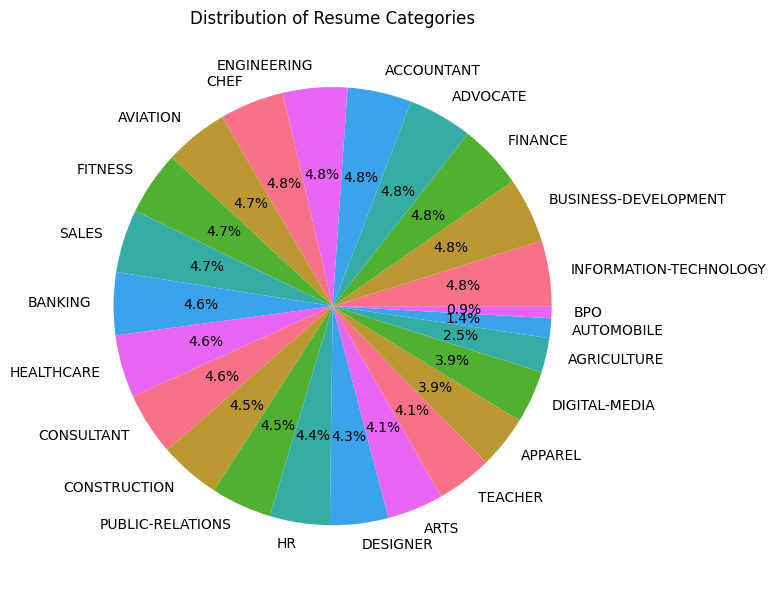

In [8]:
# Distribution of Resume Categories
plt.figure(figsize=(8, 6))
plt.pie(
    resume_category_counts.values,
    labels=resume_category_counts.index,
    autopct='%1.1f%%'
)
plt.title('Distribution of Resume Categories')
plt.tight_layout()
plt.show()

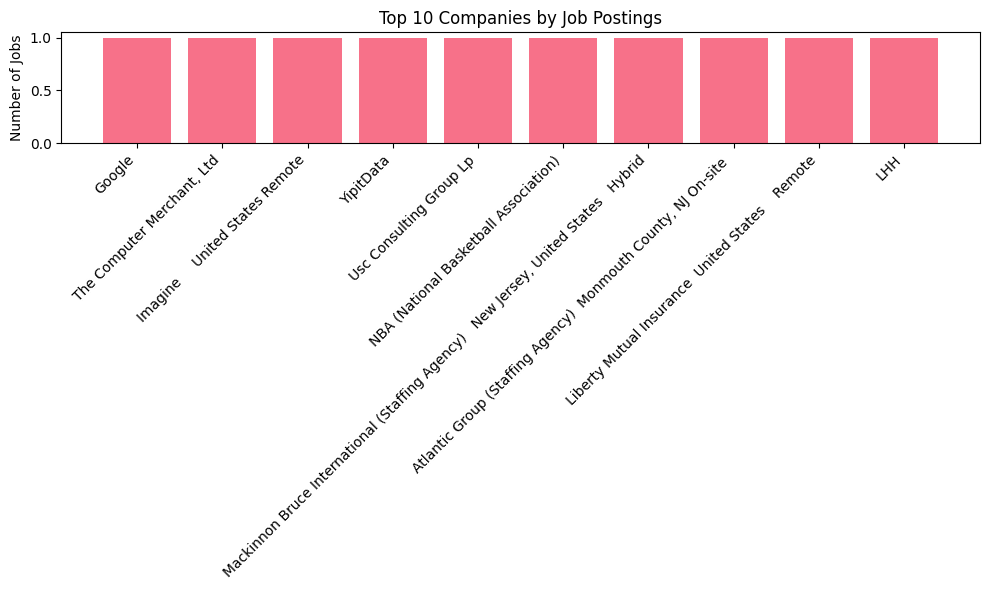

In [9]:
# Top 10 Companies by Job Postings
top_companies = jd_company_counts.head(10)
plt.figure(figsize=(10, 6))
plt.bar(
    range(len(top_companies)),
    top_companies.values
)
plt.xticks(
    range(len(top_companies)),
    top_companies.index,
    rotation=45,
    ha='right'
)
plt.ylabel('Number of Jobs')
plt.title('Top 10 Companies by Job Postings')
plt.tight_layout()
plt.show()

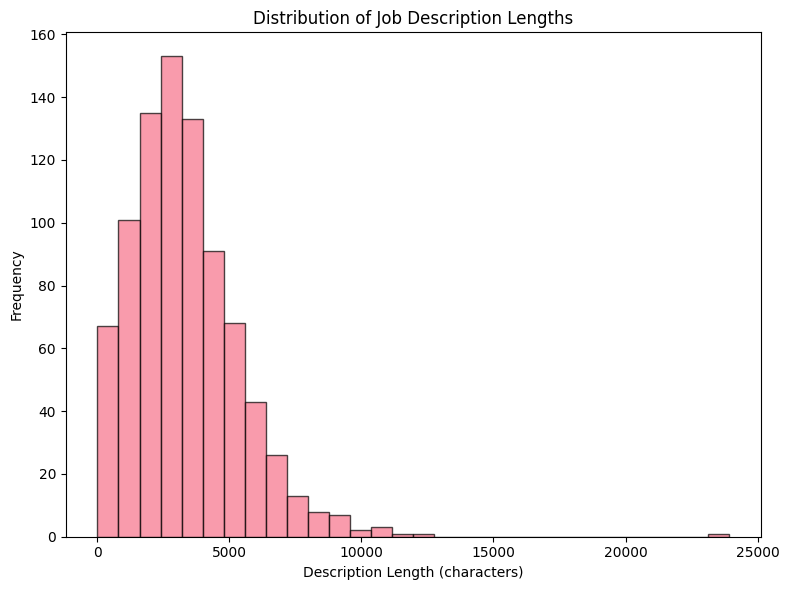

In [10]:
# Distribution of Job Description Lengths
plt.figure(figsize=(8, 6))
plt.hist(
    jd_df['description_length'],
    bins=30,
    alpha=0.7,
    edgecolor='black'
)
plt.xlabel('Description Length (characters)')
plt.ylabel('Frequency')
plt.title('Distribution of Job Description Lengths')
plt.tight_layout()
plt.show()

The distribution of job description lengths is unimodal and right-skewed, with a concentration around 3,000 characters.

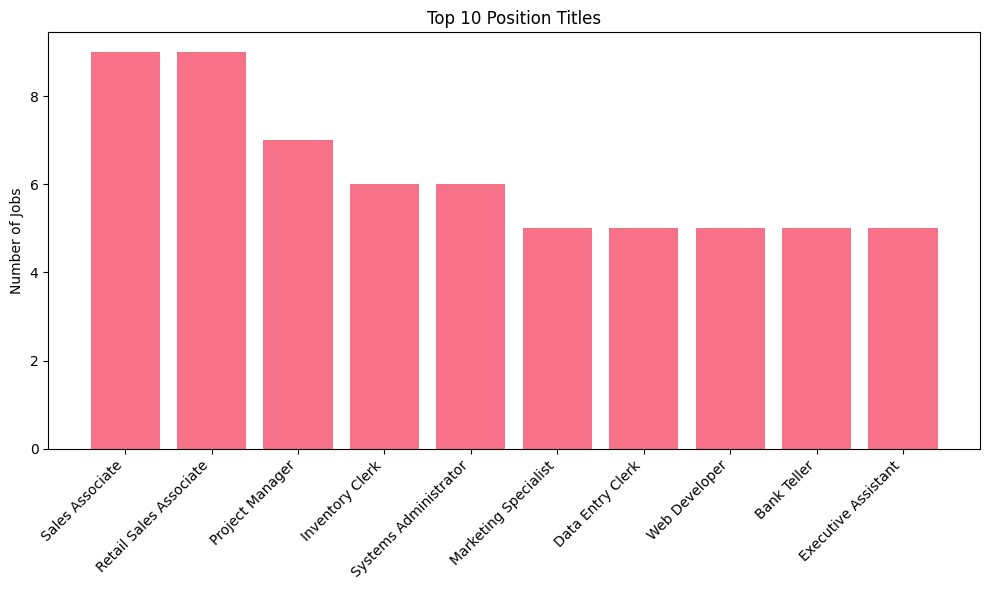

In [11]:
# Top 10 Position Titles
top_positions = jd_position_counts.head(10)
plt.figure(figsize=(10, 6))
plt.bar(
    range(len(top_positions)),
    top_positions.values
)
plt.xticks(
    range(len(top_positions)),
    top_positions.index,
    rotation=45,
    ha='right'
)
plt.ylabel('Number of Jobs')
plt.title('Top 10 Position Titles')
plt.tight_layout()
plt.show()

In [12]:
# Text preprocessing functions with enhanced stopword removal
class TextPreprocessor:
    def __init__(self):
        # Original NLTK stopwords
        self.stop_words = set(stopwords.words('english'))
        
        # Additional custom stopwords as specified
        custom_stopwords = {
            "the", "or", "and", "a", "an", "as", "be", "can", "in", "of", "on", "for", "to", "with", "by", 
            "we", "will", "company", "name", "skill", "city", "state", "education", "experience", 
            "provide", "team", "time", "work", "responsibility", "other", "ensure", "include",
            "job", "apply", "need", "store", "that", "base", "benefit", "employee", "analytical", 
            "business", "development", "sale", "engineering", "you", "all", "at", "from", "have", 
            "this", "it", "not", "s"
        }
        
        # Combine both sets of stopwords
        self.stop_words.update(custom_stopwords)
        
        self.lemmatizer = WordNetLemmatizer()
        
    def get_wordnet_pos(self, word): # Map POS tag to first character lemmatizer expects
        tag = nltk.pos_tag([word])[0][1][0].upper()
        tag_dict = {"J": wordnet.ADJ, "N": wordnet.NOUN, "V": wordnet.VERB, "R": wordnet.ADV}
        return tag_dict.get(tag, wordnet.NOUN)
    
    def clean_text(self, text): # Clean text by removing special characters, digits, and extra whitespace
        if pd.isna(text): 
            return ""
        
        # Convert to lowercase
        text = text.lower()
        
        # Remove HTML tags
        text = re.sub(r'<[^>]+>', '', text)
        
        # Remove URLs
        text = re.sub(r'http\S+|www\S+|https\S+', '', text)
        
        # Remove email addresses
        text = re.sub(r'\S+@\S+', '', text)
        
        # Remove phone numbers
        text = re.sub(r'\+?\d[\d\s\-\(\)]+', '', text)
        
        # Remove non-ASCII characters
        text = re.sub(r'[^\x00-\x7F]+', '', text)
        
        # Remove punctuation and digits
        text = re.sub(r'[^\w\s]', ' ', text)
        text = re.sub(r'\d+', '', text)
        
        # Remove extra whitespace
        text = re.sub(r'\s+', ' ', text).strip()
        
        return text
    
    def tokenize_and_lemmatize(self, text): # Tokenize text and lemmatize words
        if not text:
            return []
        
        # Tokenize
        tokens = word_tokenize(text)
        
        # Remove stopwords and lemmatize
        processed_tokens = []
        for token in tokens:
            if token not in self.stop_words and len(token) > 2:
                lemmatized = self.lemmatizer.lemmatize(token, self.get_wordnet_pos(token))
                processed_tokens.append(lemmatized)
        
        return processed_tokens
    
    def preprocess_text(self, text): # Complete preprocessing pipeline
        cleaned = self.clean_text(text)
        tokens = self.tokenize_and_lemmatize(cleaned)
        return ' '.join(tokens)

# Initialize preprocessor with enhanced stopwords and clean the data
preprocessor = TextPreprocessor()

# Preprocess resume data
resume_df['cleaned_resume'] = resume_df['Resume_str'].apply(preprocessor.preprocess_text)

# Preprocess job description data
jd_df['cleaned_job_description'] = jd_df['job_description'].apply(preprocessor.preprocess_text)

print(f"Total stopwords being filtered: {len(preprocessor.stop_words)}")

# Check preprocessing results
print(resume_df['cleaned_resume'].iloc[0][:500])

print(jd_df['cleaned_job_description'].iloc[0][:500])

Total stopwords being filtered: 224
administrator marketing associate administrator summary dedicate customer service manager year hospitality customer service management respect builder leader customer focus team strives instill share enthusiastic commitment customer service highlight focus customer satisfaction management marketing savvy conflict resolution technique training skilled multi tasker client relation specialist accomplishment missouri dot supervisor training certification certify ihg customer loyalty marketing segmen
minimum qualification bachelor degree equivalent practical year saas productivity tool businessexperience manage enterprise account sale cycle prefer qualification year building strategic partnership enterprise customersability reseller ecosystem scale businessability plan pitch execute territory strategyability build relationship deliver result crossfunctionalmatrixed environmentability identify crosspromoting uppromoting opportunity within exist account bas

In [13]:
# Initialize preprocessor and clean the data
preprocessor = TextPreprocessor()

# Preprocess resume data
resume_df['cleaned_resume'] = resume_df['Resume_str'].apply(preprocessor.preprocess_text)

# Preprocess job description data
jd_df['cleaned_job_description'] = jd_df['job_description'].apply(preprocessor.preprocess_text)

# Check preprocessing results
print("\nSample of cleaned resume text:")
print(resume_df['cleaned_resume'].iloc[0][:500])

print("\nSample of cleaned job description text:")
print(jd_df['cleaned_job_description'].iloc[0][:500])


Sample of cleaned resume text:
administrator marketing associate administrator summary dedicate customer service manager year hospitality customer service management respect builder leader customer focus team strives instill share enthusiastic commitment customer service highlight focus customer satisfaction management marketing savvy conflict resolution technique training skilled multi tasker client relation specialist accomplishment missouri dot supervisor training certification certify ihg customer loyalty marketing segmen

Sample of cleaned job description text:
minimum qualification bachelor degree equivalent practical year saas productivity tool businessexperience manage enterprise account sale cycle prefer qualification year building strategic partnership enterprise customersability reseller ecosystem scale businessability plan pitch execute territory strategyability build relationship deliver result crossfunctionalmatrixed environmentability identify crosspromoting uppromoting

In [14]:
# Check preprocessing results

for i in range(10):
    print(f"\nSample of cleaned resume {i} text:")
    print(resume_df['cleaned_resume'].iloc[i][:1000])

    print(f"\nSample of cleaned job description {i} text:")
    print(jd_df['cleaned_job_description'].iloc[i][:1000])


Sample of cleaned resume 0 text:
administrator marketing associate administrator summary dedicate customer service manager year hospitality customer service management respect builder leader customer focus team strives instill share enthusiastic commitment customer service highlight focus customer satisfaction management marketing savvy conflict resolution technique training skilled multi tasker client relation specialist accomplishment missouri dot supervisor training certification certify ihg customer loyalty marketing segment hilton worldwide general manager training certification accomplish trainer cross server hospitality system hilton onq micros opera pm fidelio opera reservation system or holidex complete course seminar customer service sale strategy inventory control loss prevention safety management leadership performance assessment administrator marketing associate administrator dec current help develop policy directs coordinate activity employment compensation labor relatio

In [15]:
# Word frequency analysis by job category from a list of texts
def get_word_frequencies(texts, top_n=20):
    all_words = []
    for text in texts:
        if pd.notna(text) and text:
            all_words.extend(text.split())
    
    word_freq = Counter(all_words)
    return word_freq.most_common(top_n)

# Analyze word frequencies by resume category
categories = resume_df['Category'].unique()

word_freq_by_category = {}
for category in categories:
    category_resumes = resume_df[resume_df['Category'] == category]['cleaned_resume']
    word_freq_by_category[category] = get_word_frequencies(category_resumes, top_n=15)
    
    print(f"\nTop 15 words in {category}:")
    for word, freq in word_freq_by_category[category]:
        print(f"{word}: {freq}")


Top 15 words in HR:
management: 949
resource: 616
human: 595
process: 529
training: 514
employee: 494
new: 457
program: 454
manager: 435
hire: 426
staff: 410
policy: 398
benefit: 388
skill: 376
manage: 345

Top 15 words in DESIGNER:
design: 1281
designer: 565
project: 446
create: 323
product: 313
client: 313
graphic: 296
customer: 289
skill: 273
art: 264
use: 263
work: 243
management: 227
new: 221
material: 216

Top 15 words in INFORMATION-TECHNOLOGY:
system: 1325
management: 898
information: 855
technology: 818
support: 782
network: 751
project: 707
server: 568
data: 557
software: 542
application: 444
service: 443
manage: 440
security: 434
database: 407

Top 15 words in TEACHER:
student: 1114
teacher: 707
child: 427
school: 400
skill: 399
learn: 361
classroom: 330
plan: 309
lesson: 291
activity: 278
teach: 277
parent: 256
program: 243
maintain: 241
service: 213

Top 15 words in ADVOCATE:
customer: 1006
service: 811
skill: 512
client: 482
management: 479
patient: 413
sale: 339
maintai

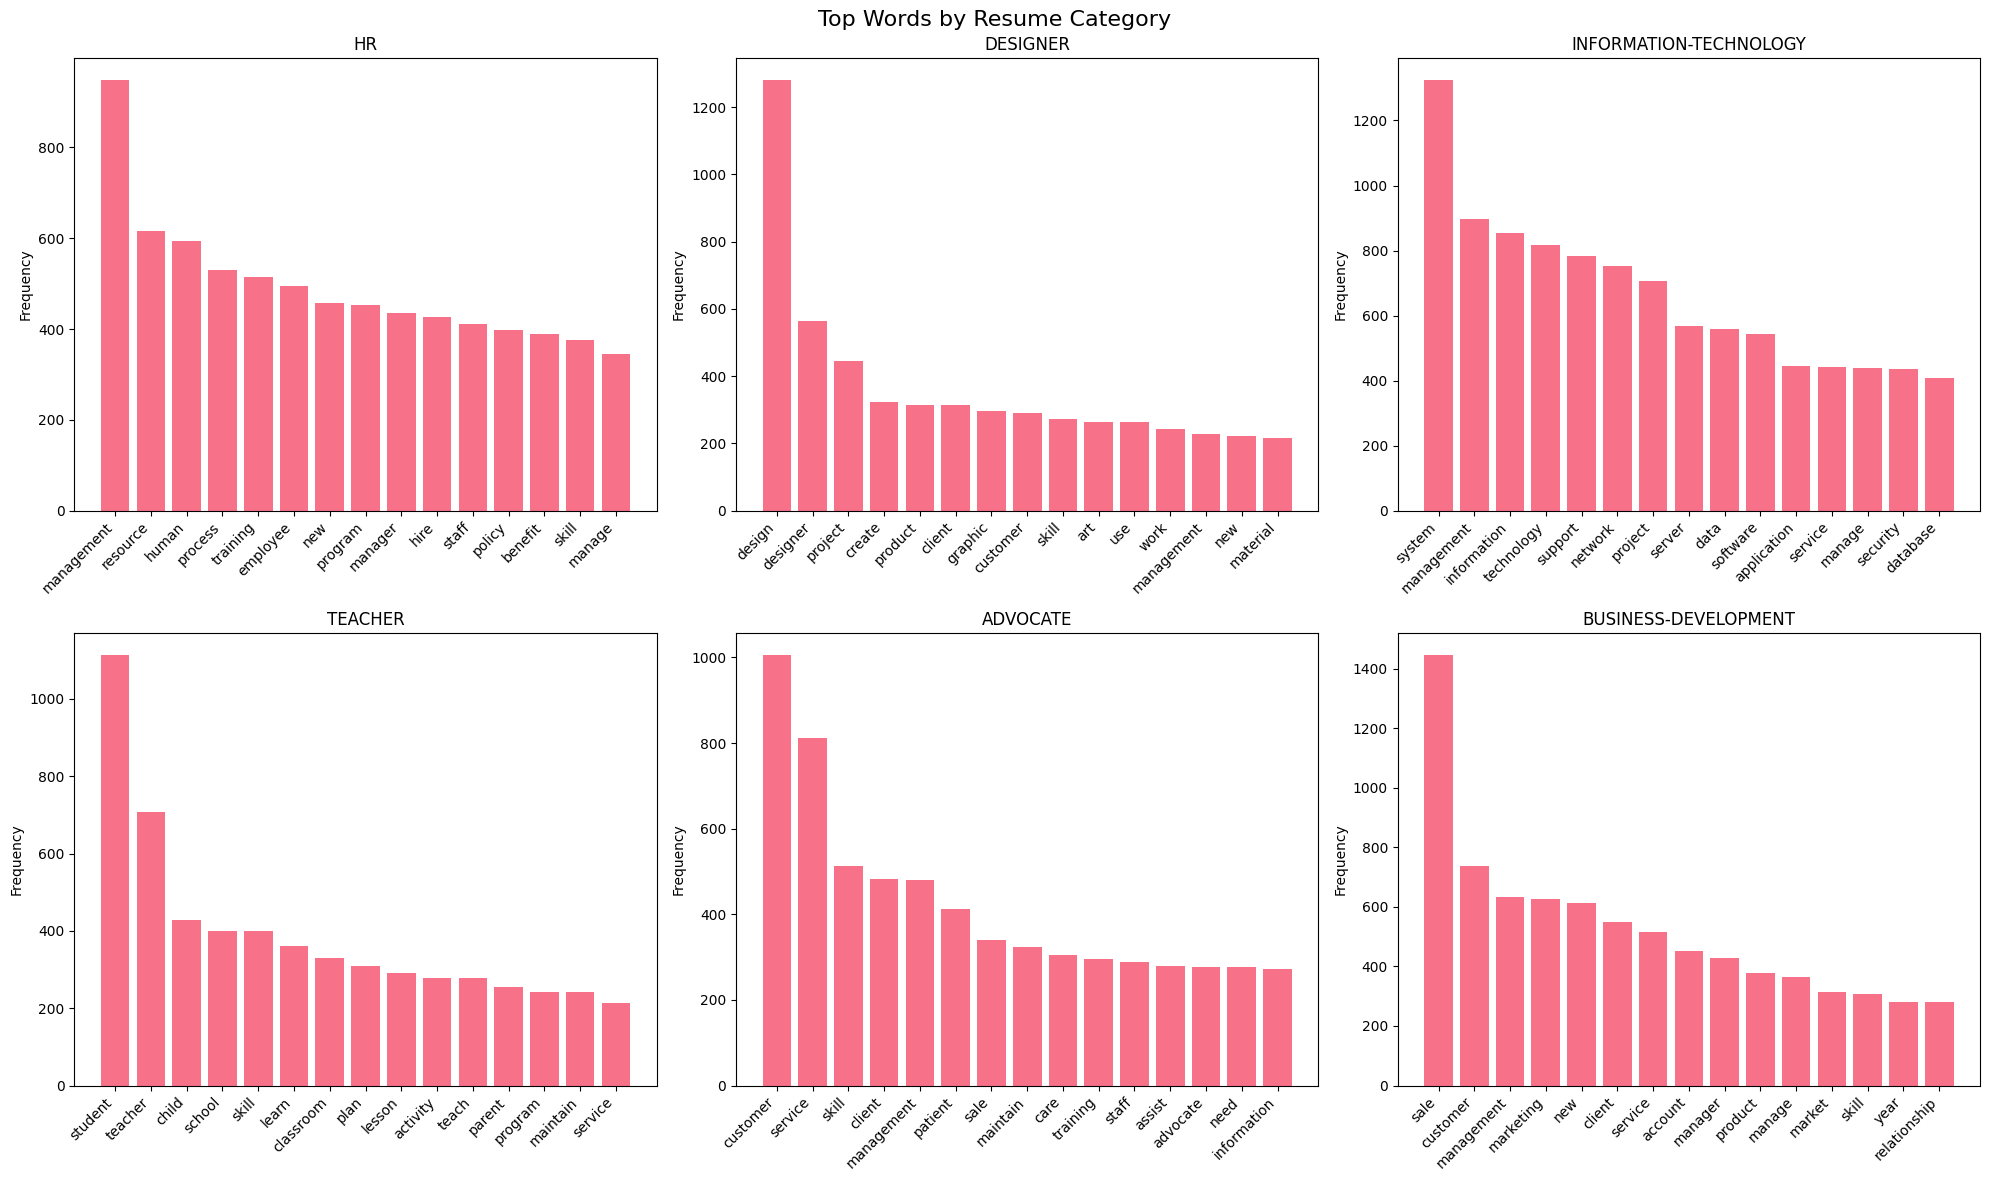

In [16]:
# Visualize word frequencies by category
def plot_word_frequency(word_freq_dict, title):
    n_categories = len(word_freq_dict)
    fig, axes = plt.subplots(2, 3, figsize=(20, 12))
    axes = axes.flatten()
    
    for i, (category, word_freq) in enumerate(word_freq_dict.items()):
        if i < len(axes):
            words = [item[0] for item in word_freq]
            freqs = [item[1] for item in word_freq]
            
            axes[i].bar(range(len(words)), freqs)
            axes[i].set_title(f'{category}')
            axes[i].set_xticks(range(len(words)))
            axes[i].set_xticklabels(words, rotation=45, ha='right')
            axes[i].set_ylabel('Frequency')
    
    # Hide unused subplots
    for i in range(len(word_freq_dict), len(axes)):
        axes[i].set_visible(False)
    
    plt.suptitle(title, fontsize=16)
    plt.tight_layout()
    plt.show()

# Plot word frequencies by resume category
plot_word_frequency(word_freq_by_category, 'Top Words by Resume Category')

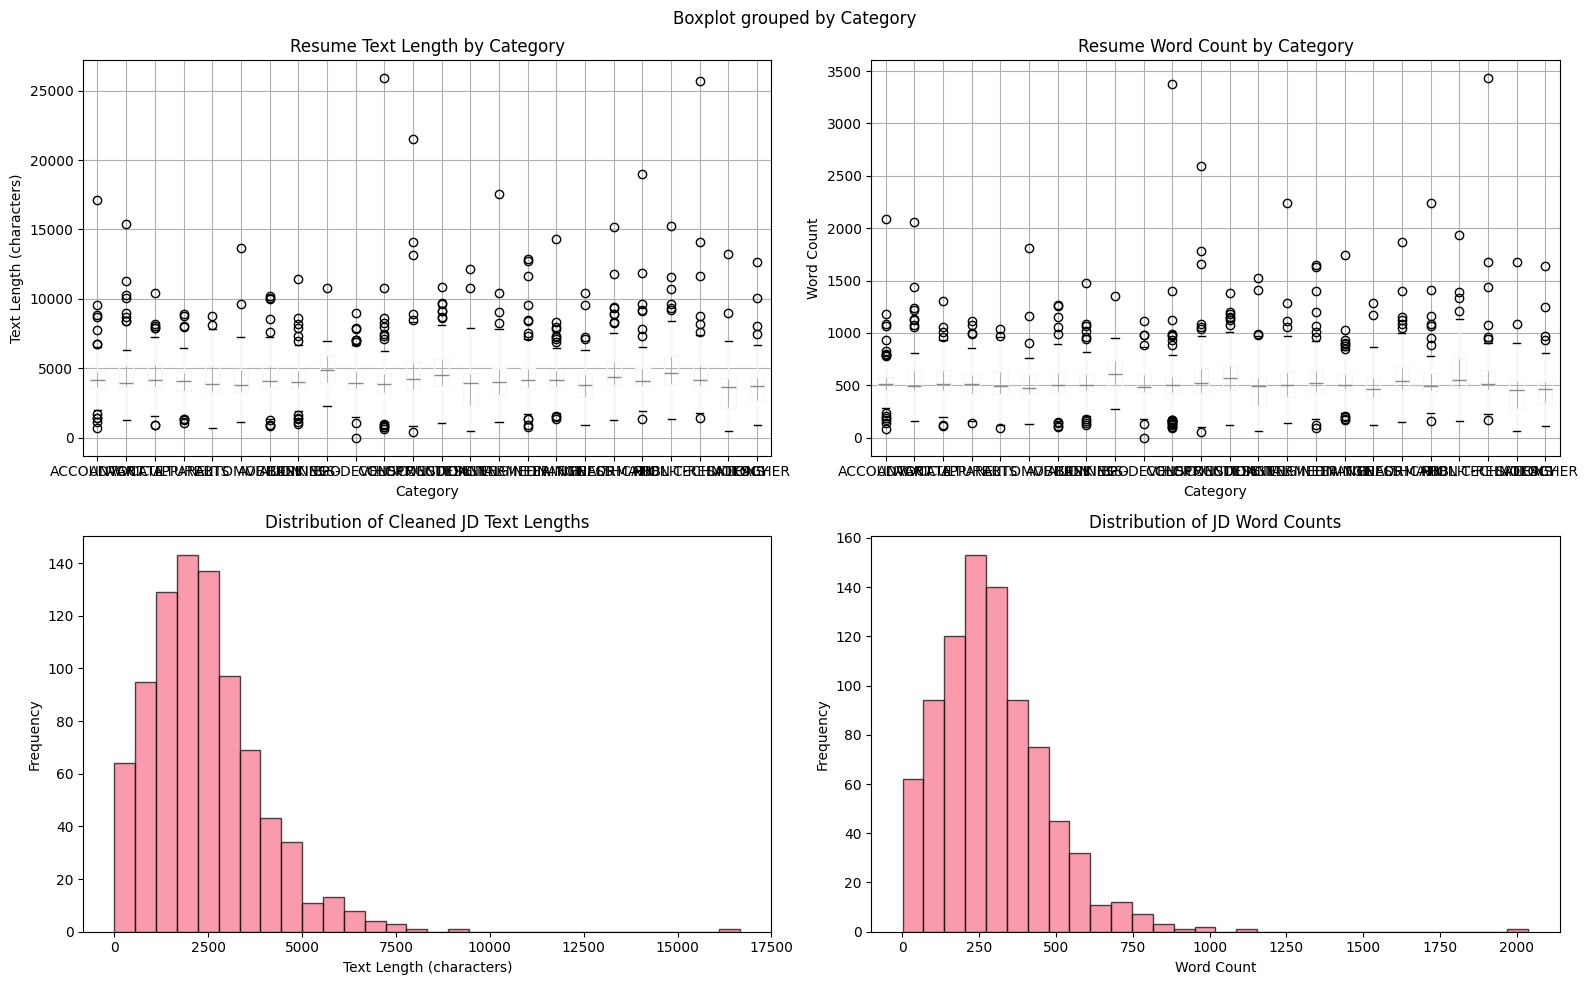

In [17]:
# Text length analysis
resume_df['text_length'] = resume_df['cleaned_resume'].str.len()
resume_df['word_count'] = resume_df['cleaned_resume'].str.split().str.len()

jd_df['cleaned_text_length'] = jd_df['cleaned_job_description'].str.len()
jd_df['word_count'] = jd_df['cleaned_job_description'].str.split().str.len()

# Visualize text statistics
fig, axes = plt.subplots(2, 2, figsize=(16, 10))

# Resume text length by category
resume_df.boxplot(column='text_length', by='Category', ax=axes[0, 0])
axes[0, 0].set_title('Resume Text Length by Category')
axes[0, 0].set_xlabel('Category')
axes[0, 0].set_ylabel('Text Length (characters)')

# Resume word count by category
resume_df.boxplot(column='word_count', by='Category', ax=axes[0, 1])
axes[0, 1].set_title('Resume Word Count by Category')
axes[0, 1].set_xlabel('Category')
axes[0, 1].set_ylabel('Word Count')

# JD text length distribution
axes[1, 0].hist(jd_df['cleaned_text_length'], bins=30, alpha=0.7, edgecolor='black')
axes[1, 0].set_title('Distribution of Cleaned JD Text Lengths')
axes[1, 0].set_xlabel('Text Length (characters)')
axes[1, 0].set_ylabel('Frequency')

# JD word count distribution
axes[1, 1].hist(jd_df['word_count'], bins=30, alpha=0.7, edgecolor='black')
axes[1, 1].set_title('Distribution of JD Word Counts')
axes[1, 1].set_xlabel('Word Count')
axes[1, 1].set_ylabel('Frequency')

plt.tight_layout()
plt.show()

## üî∏ Detyra 2: P√´rputhja e CV-ve me JD

### TF-IDF approach

In [18]:
# Initialize TF-IDF vectorizer with optimized parameters
tfidf_vectorizer = TfidfVectorizer(
    max_features=5000,
    ngram_range=(1, 2),
    min_df=2,
    max_df=0.8,
    sublinear_tf=True
)

# Combine all texts for fitting the vectorizer
all_texts_combined = list(resume_df['cleaned_resume'].fillna('')) + list(jd_df['cleaned_job_description'].fillna(''))

# Fit and transform texts using TF-IDF
tfidf_vectorizer.fit(all_texts_combined)
resume_tfidf_matrix = tfidf_vectorizer.transform(resume_df['cleaned_resume'].fillna(''))
jd_tfidf_matrix = tfidf_vectorizer.transform(jd_df['cleaned_job_description'].fillna(''))

# Compute cosine similarity matrix for TF-IDF
similarity_matrix_tfidf = cosine_similarity(resume_tfidf_matrix, jd_tfidf_matrix)

print(f"TF-IDF Results:")
print(f"Resume TF-IDF matrix shape: {resume_tfidf_matrix.shape}")
print(f"JD TF-IDF matrix shape: {jd_tfidf_matrix.shape}")
print(f"Similarity matrix shape: {similarity_matrix_tfidf.shape}")
print(f"Min similarity: {similarity_matrix_tfidf.min():.4f}")
print(f"Max similarity: {similarity_matrix_tfidf.max():.4f}")
print(f"Mean similarity: {similarity_matrix_tfidf.mean():.4f}")
print(f"Standard deviation: {similarity_matrix_tfidf.std():.4f}")

TF-IDF Results:
Resume TF-IDF matrix shape: (2484, 5000)
JD TF-IDF matrix shape: (853, 5000)
Similarity matrix shape: (2484, 853)
Min similarity: 0.0000
Max similarity: 0.4307
Mean similarity: 0.0723
Standard deviation: 0.0344


### Word2Vec approach

In [19]:
from gensim.models import Word2Vec

In [20]:
# Prepare tokenized sentences for Word2Vec training
def prepare_word2vec_sentences(df, text_column):
    sentences = []
    for text in df[text_column].fillna(''):
        if text:
            words = text.split()
            if words:
                sentences.append(words)
    return sentences

# Convert document to vector by averaging word vectors (or sum but this is trivial)
def get_document_vector_word2vec(text, model, vector_size=200): 
    if not text:
        return np.zeros(vector_size)
    
    words = text.split()
    word_vectors = []
    
    for word in words:
        if word in model.wv.key_to_index:
            word_vectors.append(model.wv[word])
    
    if word_vectors:
        return np.mean(word_vectors, axis=0)
    else:
        return np.zeros(vector_size)

# Prepare data for Word2Vec training
resume_sentences_w2v = prepare_word2vec_sentences(resume_df, 'cleaned_resume')
jd_sentences_w2v = prepare_word2vec_sentences(jd_df, 'cleaned_job_description')
all_sentences_w2v = resume_sentences_w2v + jd_sentences_w2v

# Train Word2Vec model
word2vec_model = Word2Vec(
    sentences=all_sentences_w2v,
    vector_size=200,
    window=5,
    min_count=2,
    workers=4,
    epochs=10,
    sg=1
)

# Convert documents to vectors
resume_vectors_w2v = np.array([
    get_document_vector_word2vec(text, word2vec_model, 200)
    for text in resume_df['cleaned_resume'].fillna('')
])

jd_vectors_w2v = np.array([
    get_document_vector_word2vec(text, word2vec_model, 200)
    for text in jd_df['cleaned_job_description'].fillna('')
])

# Compute cosine similarity matrix for Word2Vec
similarity_matrix_word2vec = cosine_similarity(resume_vectors_w2v, jd_vectors_w2v)

print(f"\nWord2Vec Implementation Results:")
print(f"Vocabulary size: {len(word2vec_model.wv.key_to_index)}")
print(f"Resume vectors shape: {resume_vectors_w2v.shape}")
print(f"JD vectors shape: {jd_vectors_w2v.shape}")
print(f"Similarity matrix shape: {similarity_matrix_word2vec.shape}")
print(f"Min similarity: {similarity_matrix_word2vec.min():.4f}")
print(f"Max similarity: {similarity_matrix_word2vec.max():.4f}")
print(f"Mean similarity: {similarity_matrix_word2vec.mean():.4f}")
print(f"Standard deviation: {similarity_matrix_word2vec.std():.4f}")


Word2Vec Implementation Results:
Vocabulary size: 19947
Resume vectors shape: (2484, 200)
JD vectors shape: (853, 200)
Similarity matrix shape: (2484, 853)
Min similarity: 0.0000
Max similarity: 0.9850
Mean similarity: 0.8586
Standard deviation: 0.0651


### Sentence transformer approach

In [21]:
from sentence_transformers import SentenceTransformer

In [22]:
# Prepare texts for sentence transformer processing
def prepare_texts_for_transformer(df, text_column):
    texts = []
    for text in df[text_column].fillna(''):
        if text.strip():
            texts.append(text.strip())
        else:
            texts.append('')
    return texts

# Load pre-trained sentence transformer model
sentence_transformer_model = SentenceTransformer('all-MiniLM-L6-v2')

# Prepare texts for transformer
resume_texts_transformer = prepare_texts_for_transformer(resume_df, 'cleaned_resume')
jd_texts_transformer = prepare_texts_for_transformer(jd_df, 'cleaned_job_description')

# Generate embeddings for resumes and job descriptions
resume_embeddings_transformer = sentence_transformer_model.encode(
    resume_texts_transformer,
    show_progress_bar=True,
    batch_size=32,
    convert_to_tensor=False
)

jd_embeddings_transformer = sentence_transformer_model.encode(
    jd_texts_transformer,
    show_progress_bar=True,
    batch_size=32,
    convert_to_tensor=False
)

# Compute cosine similarity matrix for Sentence Transformer
similarity_matrix_transformer = cosine_similarity(resume_embeddings_transformer, jd_embeddings_transformer)

print(f"\nSentence Transformer Implementation Results:")
print(f"Model: all-MiniLM-L6-v2")
print(f"Resume embeddings shape: {resume_embeddings_transformer.shape}")
print(f"JD embeddings shape: {jd_embeddings_transformer.shape}")
print(f"Similarity matrix shape: {similarity_matrix_transformer.shape}")
print(f"Min similarity: {similarity_matrix_transformer.min():.4f}")
print(f"Max similarity: {similarity_matrix_transformer.max():.4f}")
print(f"Mean similarity: {similarity_matrix_transformer.mean():.4f}")
print(f"Standard deviation: {similarity_matrix_transformer.std():.4f}")

Batches: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 27/27 [00:29<00:00,  1.08s/it]


Sentence Transformer Implementation Results:
Model: all-MiniLM-L6-v2
Resume embeddings shape: (2484, 384)
JD embeddings shape: (853, 384)
Similarity matrix shape: (2484, 853)
Min similarity: -0.1161
Max similarity: 0.8910
Mean similarity: 0.5149
Standard deviation: 0.1319


### A few eaxmples and visualization

In [23]:
# Find top N matching job descriptions for a given resume
def find_top_jd_matches_unified(resume_idx, similarity_matrix, method_name, n_matches=5):
    similarities = similarity_matrix[resume_idx]
    top_indices = np.argsort(similarities)[-n_matches:][::-1]
    
    matches = []
    for idx in top_indices:
        matches.append({
            'jd_idx': idx,
            'similarity': similarities[idx],
            'company': jd_df.iloc[idx]['company_name'],
            'position': jd_df.iloc[idx]['position_title'],
            'description_preview': jd_df.iloc[idx]['job_description'][:200],
            'method': method_name
        })
    
    return matches

# Find top N matching resumes for a given job description
def find_top_resume_matches_unified(jd_idx, similarity_matrix, method_name, n_matches=5):
    similarities = similarity_matrix[:, jd_idx]
    top_indices = np.argsort(similarities)[-n_matches:][::-1]
    
    matches = []
    for idx in top_indices:
        matches.append({
            'resume_idx': idx,
            'similarity': similarities[idx],
            'category': resume_df.iloc[idx]['Category'],
            'resume_preview': resume_df.iloc[idx]['Resume_str'][:200],
            'method': method_name
        })
    
    return matches

# Store all similarity matrices in a dictionary for easy access
similarity_matrices = {
    'TF-IDF': similarity_matrix_tfidf,
    'Word2Vec': similarity_matrix_word2vec,
    'all-MiniLM-L6-v2': similarity_matrix_transformer
}

# Demonstrate top matches for first 3 resumes using all methods
for resume_idx in range(min(3, len(resume_df))):
    print(f"Resume {resume_idx+1} (Category: {resume_df.iloc[resume_idx]['Category']}):")
    print(f"Resume preview: {resume_df.iloc[resume_idx]['Resume_str'][:150]}...")
    
    for method_name, sim_matrix in similarity_matrices.items():
        print(f"\n{method_name} - Top 5 matching job descriptions:")
        matches = find_top_jd_matches_unified(resume_idx, sim_matrix, method_name, n_matches=5)
        
        for i, match in enumerate(matches, 1):
            print(f"  {i}. {match['company']} - {match['position']} (Similarity: {match['similarity']:.4f})")
    print(f"\n")

Resume 1 (Category: HR):
Resume preview:          HR ADMINISTRATOR/MARKETING ASSOCIATE

HR ADMINISTRATOR       Summary     Dedicated Customer Service Manager with 15+ years of experience in H...

TF-IDF - Top 5 matching job descriptions:
  1. Marriott - Sales Executive Richmond Hotel (Similarity: 0.1800)
  2. Aveda Institutes - Human Resources Generalist (Similarity: 0.1708)
  3. PNC Bank - Investment Service Partner ‚Äì Customer Service Rep ‚Äì REMOTE OPTION (Similarity: 0.1587)
  4. PNC Financial Services Group - Sales Leader I - Business Banking Sales Manager (Similarity: 0.1530)
  5. Marriott International - Senior Catering Sales Executive (Similarity: 0.1500)

Word2Vec - Top 5 matching job descriptions:
  1. Work With Your Handz - Service Manager (Similarity: 0.9480)
  2. Concentra - Field Sales Account Executive (Similarity: 0.9478)
  3. Bio-Reference Laboratories, Inc. - Account Executive, Urology - Ohio and parts of W.PA, W.VA (Similarity: 0.9477)
  4. Brooklyn Public Library -

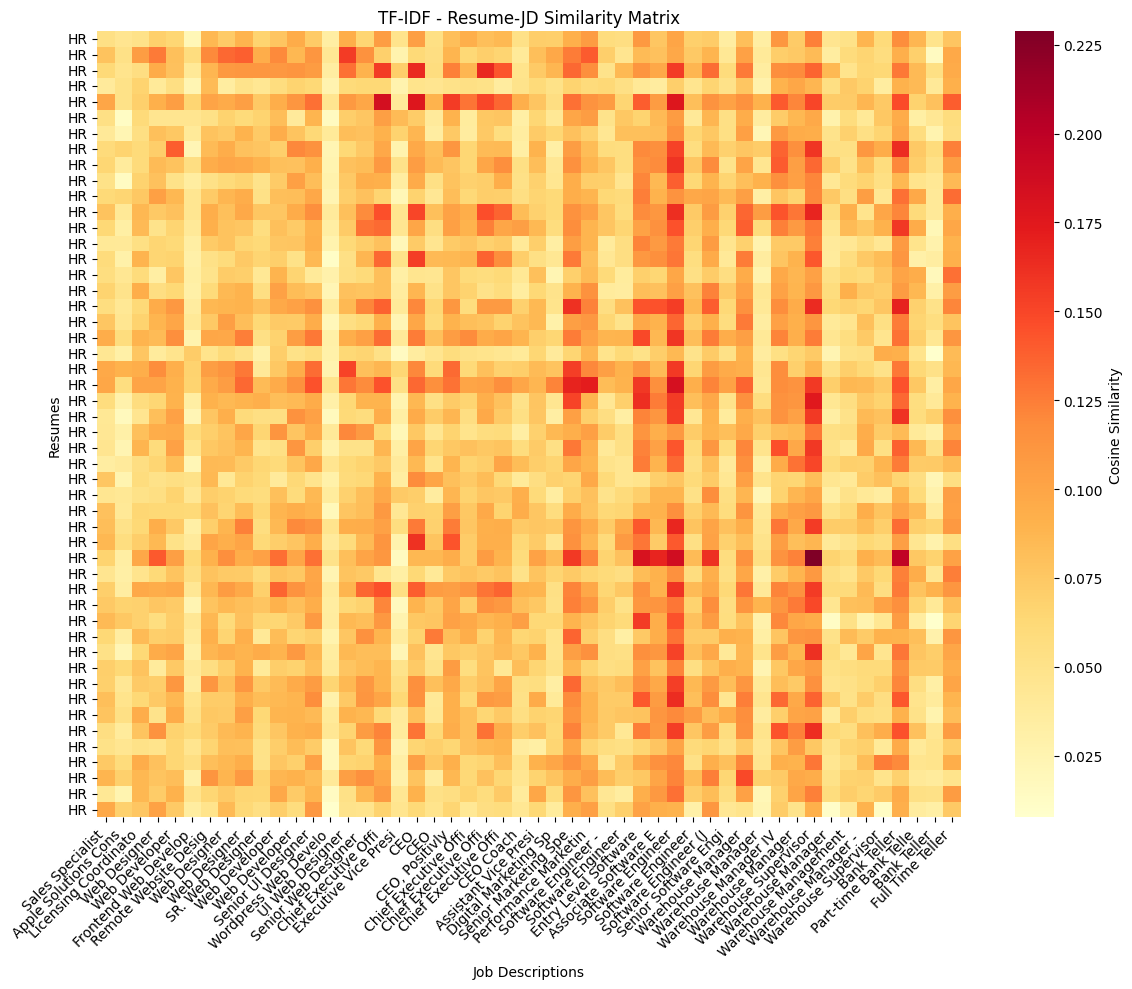

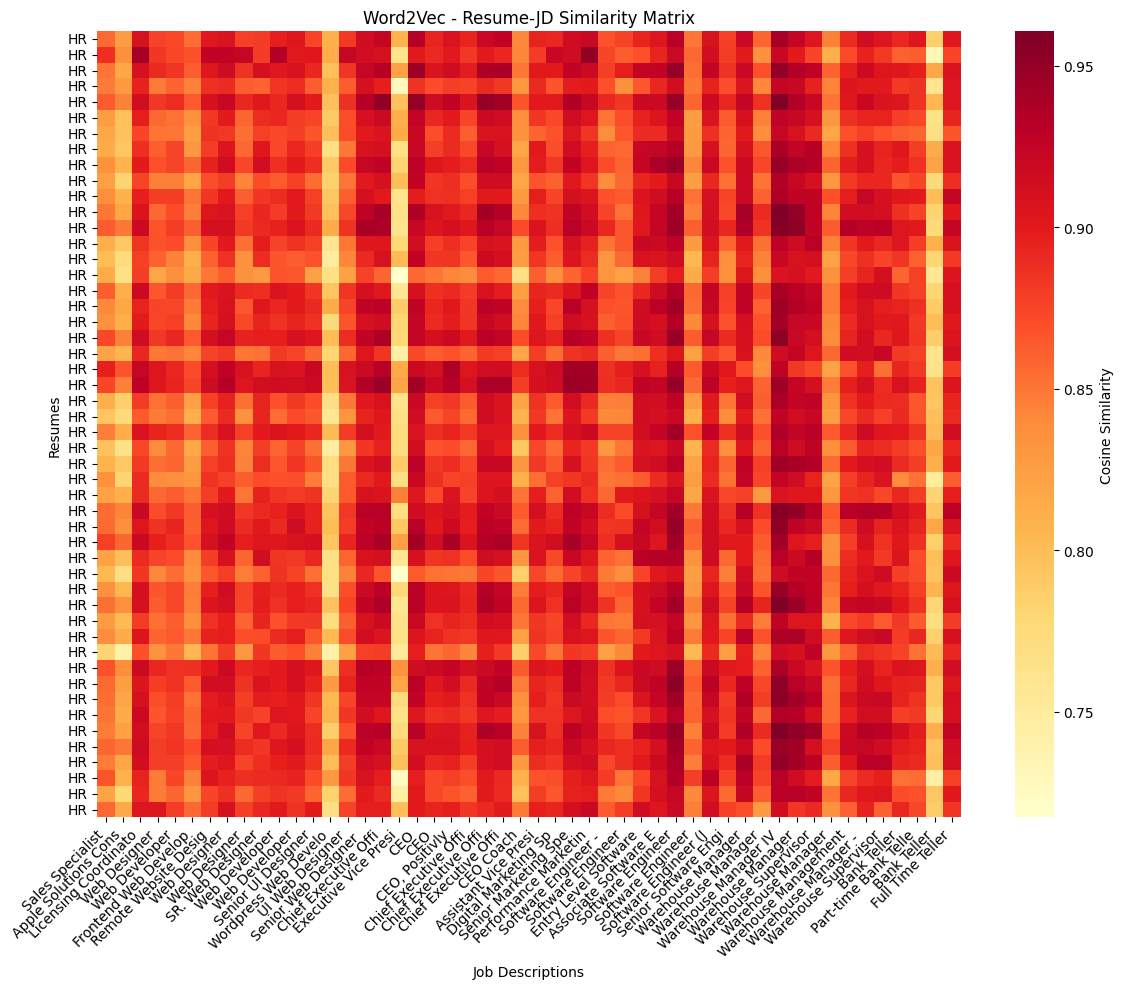

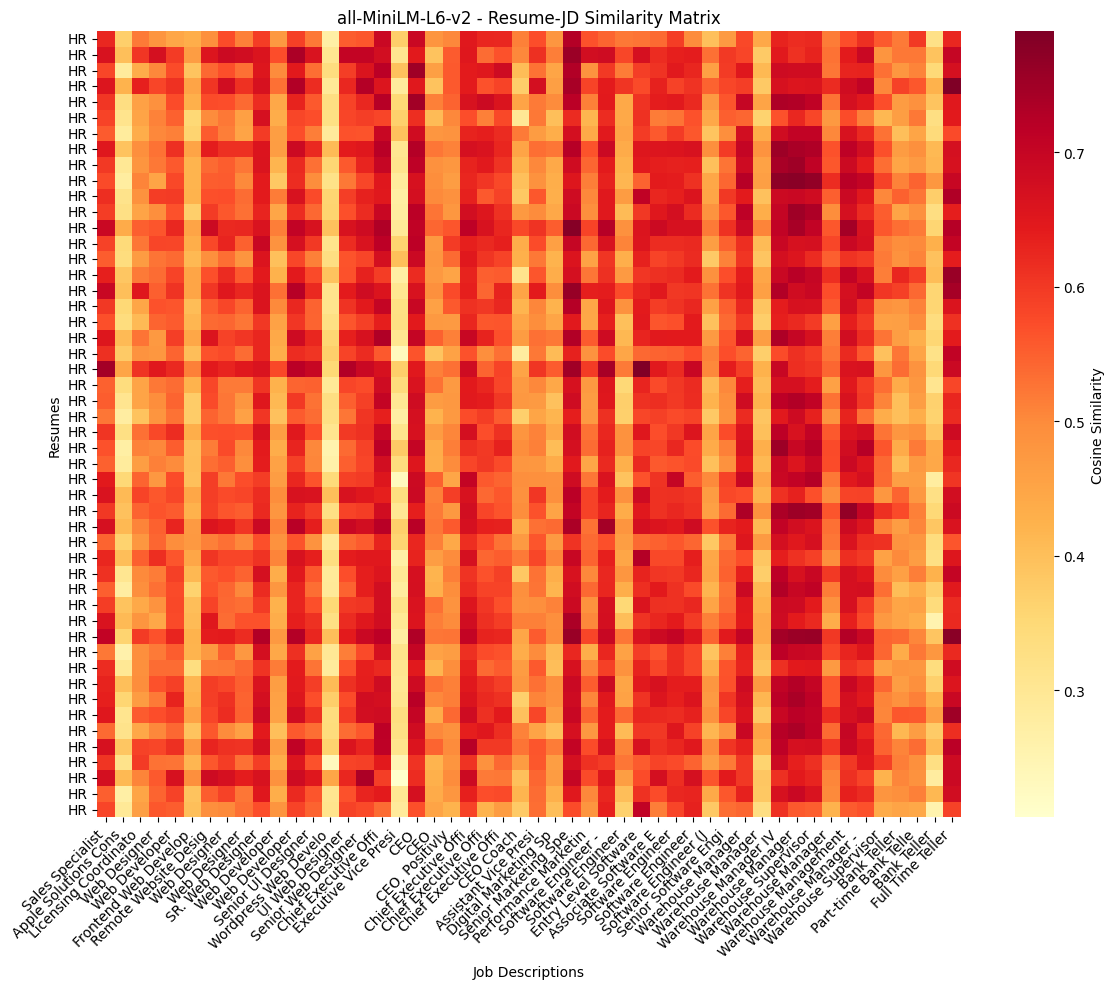

In [24]:
# Create heatmap visualization for similarity matrix
def create_similarity_heatmap_unified(similarity_matrix, method_name, sample_size=50):
    sample_size = min(sample_size, len(resume_df), len(jd_df))
    sample_similarity = similarity_matrix[:sample_size, :sample_size]
    
    plt.figure(figsize=(12, 10))
    sns.heatmap(sample_similarity,
                xticklabels=jd_df.iloc[:sample_size]['position_title'].str[:20],
                yticklabels=resume_df.iloc[:sample_size]['Category'],
                cmap='YlOrRd',
                cbar_kws={'label': 'Cosine Similarity'})
    plt.title(f'{method_name} - Resume-JD Similarity Matrix')
    plt.xlabel('Job Descriptions')
    plt.ylabel('Resumes')
    plt.xticks(rotation=45, ha='right')
    plt.yticks(rotation=0)
    plt.tight_layout()
    plt.show()

# Calculate average similarity scores by resume category
def calculate_category_similarity_stats_unified(similarity_matrix, method_name):
    category_stats = {}
    for category in resume_df['Category'].unique():
        category_indices = resume_df[resume_df['Category'] == category].index
        category_similarities = similarity_matrix[category_indices]
        
        # Get top 5 matches for each resume in this category
        top_similarities = []
        for idx in range(len(category_indices)):
            top_5_scores = np.sort(category_similarities[idx])[-5:]
            top_similarities.extend(top_5_scores)
        
        category_stats[category] = {
            'mean_similarity': np.mean(top_similarities),
            'median_similarity': np.median(top_similarities),
            'std_similarity': np.std(top_similarities),
            'max_similarity': np.max(top_similarities),
            'min_similarity': np.min(top_similarities),
            'method': method_name
        }
    
    return category_stats

# Generate heatmaps for all methods
for method_name, sim_matrix in similarity_matrices.items():
    create_similarity_heatmap_unified(sim_matrix, method_name)

Now lets compare similarities against categories.

In [25]:
# Calculate category statistics for all methods
all_category_stats = {}
for method_name, sim_matrix in similarity_matrices.items():
    all_category_stats[method_name] = calculate_category_similarity_stats_unified(sim_matrix, method_name)

# Display comparison table
print("Category similarity statistics:")

for category in resume_df['Category'].unique():
    print(f"\n{category}:")
    print(f"{'Method':<20} {'Mean':<8} {'Median':<8} {'Std':<8} {'Max':<8} {'Min':<8}")
    print("-"*60)
    
    for method_name in similarity_matrices.keys():
        stats = all_category_stats[method_name][category]
        print(f"{method_name:<20} {stats['mean_similarity']:<8.4f} {stats['median_similarity']:<8.4f} "
              f"{stats['std_similarity']:<8.4f} {stats['max_similarity']:<8.4f} {stats['min_similarity']:<8.4f}")

Category similarity statistics:

HR:
Method               Mean     Median   Std      Max      Min     
------------------------------------------------------------
TF-IDF               0.2079   0.2030   0.0380   0.3446   0.1182  
Word2Vec             0.9558   0.9560   0.0086   0.9799   0.9160  
all-MiniLM-L6-v2     0.7931   0.7967   0.0347   0.8856   0.6882  

DESIGNER:
Method               Mean     Median   Std      Max      Min     
------------------------------------------------------------
TF-IDF               0.1783   0.1769   0.0432   0.3386   0.0790  
Word2Vec             0.9289   0.9348   0.0287   0.9740   0.8219  
all-MiniLM-L6-v2     0.7309   0.7400   0.0635   0.8480   0.4897  

INFORMATION-TECHNOLOGY:
Method               Mean     Median   Std      Max      Min     
------------------------------------------------------------
TF-IDF               0.2082   0.2089   0.0400   0.3419   0.1056  
Word2Vec             0.9488   0.9533   0.0178   0.9797   0.8509  
all-MiniLM-L6-v2  

Similarity distribution by category

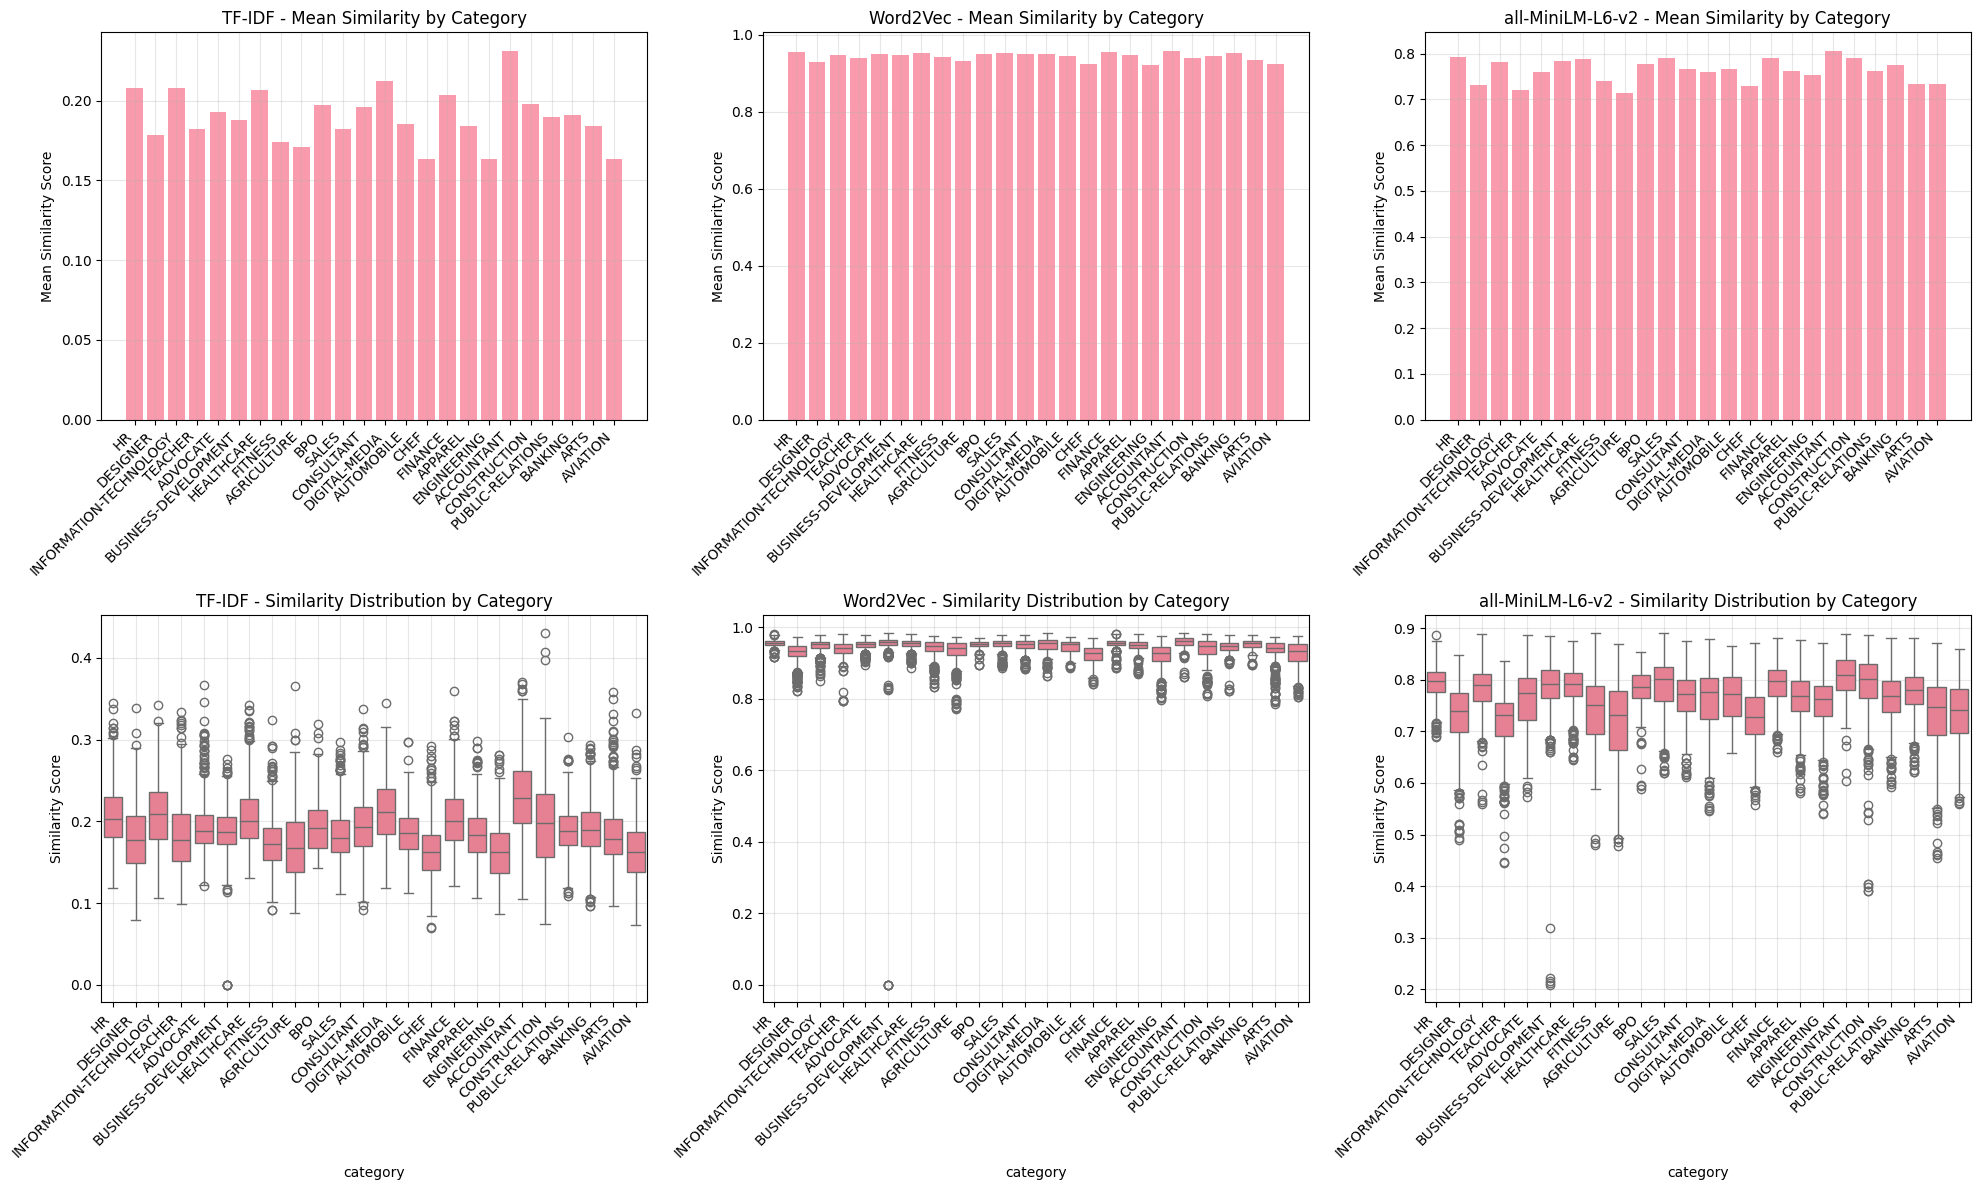

In [26]:
# Create comprehensive visualization comparing all methods
def create_comprehensive_similarity_plots():
    fig, axes = plt.subplots(2, 3, figsize=(20, 12))
    axes = axes.flatten()
    
    # Plot 1-3: Mean similarity by category for each method
    for i, (method_name, sim_matrix) in enumerate(similarity_matrices.items()):
        categories = list(resume_df['Category'].unique())
        mean_similarities = []
        
        for category in categories:
            category_indices = resume_df[resume_df['Category'] == category].index
            category_similarities = sim_matrix[category_indices]
            
            top_similarities = []
            for idx in range(len(category_indices)):
                top_5_scores = np.sort(category_similarities[idx])[-5:]
                top_similarities.extend(top_5_scores)
            
            mean_similarities.append(np.mean(top_similarities))
        
        axes[i].bar(categories, mean_similarities, alpha=0.7)
        axes[i].set_title(f'{method_name} - Mean Similarity by Category')
        axes[i].set_ylabel('Mean Similarity Score')
        axes[i].set_xticklabels(categories, rotation=45, ha='right')
        axes[i].grid(True, alpha=0.3)
    
    # Plot 4-6: Distribution boxplots for each method
    for i, (method_name, sim_matrix) in enumerate(similarity_matrices.items()):
        plot_idx = i + 3
        
        all_top_similarities = []
        category_labels = []
        
        for category in resume_df['Category'].unique():
            category_indices = resume_df[resume_df['Category'] == category].index
            category_similarities = sim_matrix[category_indices]
            
            for idx in range(len(category_indices)):
                top_5_scores = np.sort(category_similarities[idx])[-5:]
                all_top_similarities.extend(top_5_scores)
                category_labels.extend([category] * len(top_5_scores))
        
        similarity_dist_df = pd.DataFrame({
            'similarity': all_top_similarities,
            'category': category_labels
        })
        
        sns.boxplot(data=similarity_dist_df, x='category', y='similarity', ax=axes[plot_idx])
        axes[plot_idx].set_title(f'{method_name} - Similarity Distribution by Category')
        axes[plot_idx].set_ylabel('Similarity Score')
        axes[plot_idx].set_xticklabels(resume_df['Category'].unique(), rotation=45, ha='right')
        axes[plot_idx].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()

# Create comprehensive plots
create_comprehensive_similarity_plots()

### Overall comparison

In [27]:
def calculate_overall_performance_metrics(similarity_matrix, method_name):
    return {
        'method': method_name,
        'mean_similarity': similarity_matrix.mean(),
        'median_similarity': np.median(similarity_matrix),
        'std_similarity': similarity_matrix.std(),
        'max_similarity': similarity_matrix.max(),
        'min_similarity': similarity_matrix.min(),
        'high_similarity_pairs': np.sum(similarity_matrix > 0.3),
        'very_high_similarity_pairs': np.sum(similarity_matrix > 0.5),
        'total_comparisons': similarity_matrix.size
    }

# Calculate performance metrics for all methods
performance_metrics = {}
for method_name, sim_matrix in similarity_matrices.items():
    performance_metrics[method_name] = calculate_overall_performance_metrics(sim_matrix, method_name)

# Display performance comparison
print("\nOverall Performance Comparison:")
print(f"{'Method':<20} {'Mean':<8} {'Median':<8} {'Std':<8} {'Max':<8} {'Min':<8} {'High>0.3':<10} {'VHigh>0.5':<10}")
print("~"*90)

for method_name, metrics in performance_metrics.items():
    high_sim_pct = (metrics['high_similarity_pairs'] / metrics['total_comparisons']) * 100
    very_high_sim_pct = (metrics['very_high_similarity_pairs'] / metrics['total_comparisons']) * 100
    
    print(f"{method_name:<20} {metrics['mean_similarity']:<8.4f} {metrics['median_similarity']:<8.4f} "
          f"{metrics['std_similarity']:<8.4f} {metrics['max_similarity']:<8.4f} {metrics['min_similarity']:<8.4f} "
          f"{high_sim_pct:<10.2f}% {very_high_sim_pct:<10.2f}%")


Overall Performance Comparison:
Method               Mean     Median   Std      Max      Min      High>0.3   VHigh>0.5 
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
TF-IDF               0.0723   0.0691   0.0344   0.4307   0.0000   0.01      % 0.00      %
Word2Vec             0.8586   0.8694   0.0651   0.9850   0.0000   99.95     % 99.61     %
all-MiniLM-L6-v2     0.5149   0.5277   0.1319   0.8910   -0.1161  93.73     % 58.52     %


### Save models and cleann datasets

In [28]:
import joblib

In [29]:
def save_all_models_and_results():
    # Save cleaned datasets
    resume_df.to_csv('processed_resumes.csv', index=False)
    jd_df.to_csv('processed_jds.csv', index=False)
    
    # Save TF-IDF components
    joblib.dump(tfidf_vectorizer, 'tfidf_vectorizer.pkl')
    np.save('similarity_matrix_tfidf.npy', similarity_matrix_tfidf)
    
    # Save Word2Vec components
    word2vec_model.save('word2vec_model.bin')
    np.save('resume_vectors_word2vec.npy', resume_vectors_w2v)
    np.save('jd_vectors_word2vec.npy', jd_vectors_w2v)
    np.save('similarity_matrix_word2vec.npy', similarity_matrix_word2vec)
    
    # Save Sentence Transformer components
    np.save('resume_embeddings_transformer.npy', resume_embeddings_transformer)
    np.save('jd_embeddings_transformer.npy', jd_embeddings_transformer)
    np.save('similarity_matrix_transformer.npy', similarity_matrix_transformer)
    
    # Save performance metrics
    import json
    with open('performance_metrics.json', 'w') as f:
        json.dump(performance_metrics, f, indent=2, default=str)
    
# Save all models and results
save_all_models_and_results()

## üî∫ Detyra 3: Nd√´rtimi i Modelit t√´ Vler√´simit t√´ Talenteve

***Niveli:*** Avancuar


***Objektivat:***
- P√´rdorni fushat nga `model_response` p√´r t√´ nd√´rtuar karakteristika t√´ strukturuara
- Zhvilloni nj√´ model q√´ jep nj√´ vler√´sim t√´ p√´rputhshm√´ris√´
- Testoni dhe vler√´soni performanc√´n e modelit

In [38]:
import json
import ast
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.linear_model import LinearRegression
import xgboost as xgb
from collections import defaultdict
import warnings
warnings.filterwarnings('ignore')

JSON parser for model response:

In [44]:
import json, ast, re, pandas as pd

class ModelResponseParser:
    def __init__(self):
        self.skill_keywords = set()
        self.education_keywords = set()
        self.experience_keywords = set()

    def safe_json_parse(self, raw):
        if isinstance(raw, dict):
            return raw
        if pd.isna(raw) or not isinstance(raw, str) or not raw.strip():
            return {}
        try:
            return json.loads(raw)
        except (json.JSONDecodeError, TypeError):
            try:
                return ast.literal_eval(raw)
            except Exception:
                return {}

    def _normalize_keys(self, d):
        return {
            k.lower().strip().replace(" ", "_"): v
            for k, v in d.items()
        }

    def _split_str(self, text):
        # split on periods, semicolons, or newlines into clean chunks
        parts = re.split(r'[.;\n]\s*', text)
        return [p.strip() for p in parts if p.strip()]

    def extract_skills(self, data):
        skills = []
        for field in ['required_skills', 'core_responsibilities', 'preferred_qualifications']:
            if field in data:
                val = data[field]
                if isinstance(val, list):
                    skills.extend(val)
                elif isinstance(val, str):
                    skills.extend(self._split_str(val))
        return list(set(skills))

    def extract_education(self, data):
        ed = []
        for field in ['educational_requirements', 'education']:
            if field in data:
                val = data[field]
                if isinstance(val, list):
                    ed.extend(val)
                elif isinstance(val, str):
                    ed.extend(self._split_str(val))
        return list(set(ed))

    def extract_experience(self, data):
        exp = []
        for field in ['experience_level', 'experience', 'years_experience']:
            if field in data:
                val = data[field]
                if isinstance(val, list):
                    exp.extend(val)
                elif isinstance(val, str):
                    exp.extend(self._split_str(val))
        return list(set(exp))

    def extract_all_features(self, raw):
        parsed = self.safe_json_parse(raw)
        parsed = self._normalize_keys(parsed)
        skills    = self.extract_skills(parsed)
        education = self.extract_education(parsed)
        exp       = self.extract_experience(parsed)
        # update global sets
        self.skill_keywords.update(skills)
        self.education_keywords.update(education)
        self.experience_keywords.update(exp)
        return {
            'skills':    skills,
            'education': education,
            'experience':exp,
            'raw_json':  parsed
        }

Feature engineering techniques for talent scoring:

In [45]:
# Create features for talent scoring model
class TalentScoringFeatureEngineer: 
    
    def __init__(self, parser):
        self.parser = parser
        self.skill_vectorizer = None
        self.edu_vectorizer = None
        self.scaler = StandardScaler()
        
    # Create skill matching features
    def create_skill_match_features(self, resume_text, jd_skills): 
        if not jd_skills:
            return {
                'skill_match_count': 0,
                'skill_match_ratio': 0.0,
                'skill_coverage': 0.0
            }
        
        resume_lower = resume_text.lower()
        matches = 0
        
        for skill in jd_skills:
            if skill and skill in resume_lower:
                matches += 1
        
        return {
            'skill_match_count': matches,
            'skill_match_ratio': matches / len(jd_skills) if jd_skills else 0.0,
            'skill_coverage': matches / len(set(jd_skills)) if jd_skills else 0.0
        }
    
    # Create education matching features
    def create_education_match_features(self, resume_text, jd_education): 
        if not jd_education:
            return {
                'edu_match_count': 0,
                'edu_match_present': 0
            }
        
        resume_lower = resume_text.lower()
        matches = 0
        
        # Common education keywords
        edu_keywords = ['bachelor', 'master', 'phd', 'degree', 'diploma', 
                       'university', 'college', 'graduate', 'undergraduate']
        
        for edu in jd_education:
            if edu and edu in resume_lower:
                matches += 1
        
        # Check for general education presence
        edu_present = any(keyword in resume_lower for keyword in edu_keywords)
        
        return {
            'edu_match_count': matches,
            'edu_match_present': 1 if edu_present else 0
        }
    
    # Create experience matching features
    def create_experience_match_features(self, resume_text, jd_experience): 
        if not jd_experience:
            return {
                'exp_match_count': 0,
                'exp_years_mentioned': 0
            }
        
        resume_lower = resume_text.lower()
        matches = 0
        
        for exp in jd_experience:
            if exp and exp in resume_lower:
                matches += 1
        
        # Extract years mentioned in resume
        import re
        year_pattern = r'\b(\d{1,2})\s*(?:years?|yrs?)\b'
        years_found = re.findall(year_pattern, resume_lower)
        max_years = max([int(y) for y in years_found], default=0)
        
        return {
            'exp_match_count': matches,
            'exp_years_mentioned': max_years
        }
    
    # Create text similarity features using pre-computed matrices
    def create_text_similarity_features(self, resume_text, jd_text, similarity_matrices):
        # This will be filled with similarity scores from Task 2
        return {
            'tfidf_similarity': 0.0,
            'word2vec_similarity': 0.0,
            'transformer_similarity': 0.0
        }
    
    # Create all features for a resume-JD pair
    def create_comprehensive_features(self, resume_idx, jd_idx, resume_df, jd_df, similarity_matrices):
        
        # Get resume and JD data
        resume_text = resume_df.iloc[resume_idx]['cleaned_resume']
        jd_text = jd_df.iloc[jd_idx]['cleaned_job_description']
        jd_model_response = jd_df.iloc[jd_idx]['model_response']
        
        # Parse JD model response
        jd_features = self.parser.extract_all_features(jd_model_response)
        
        # Create feature dictionary
        features = {}
        
        # 1. Skill matching features
        skill_features = self.create_skill_match_features(resume_text, jd_features['skills'])
        features.update(skill_features)
        
        # 2. Education matching features
        edu_features = self.create_education_match_features(resume_text, jd_features['education'])
        features.update(edu_features)
        
        # 3. Experience matching features
        exp_features = self.create_experience_match_features(resume_text, jd_features['experience'])
        features.update(exp_features)
        
        # 4. Text similarity features
        features['tfidf_similarity'] = similarity_matrices['TF-IDF'][resume_idx, jd_idx]
        features['word2vec_similarity'] = similarity_matrices['Word2Vec'][resume_idx, jd_idx]
        features['transformer_similarity'] = similarity_matrices['all-MiniLM-L6-v2'][resume_idx, jd_idx]
        
        # 5. Text length features
        features['resume_length'] = len(resume_text)
        features['jd_length'] = len(jd_text)
        features['length_ratio'] = len(resume_text) / len(jd_text) if len(jd_text) > 0 else 0
        
        # 6. Category matching (if available)
        resume_category = resume_df.iloc[resume_idx]['Category']
        jd_position = jd_df.iloc[jd_idx]['position_title'].lower()
        
        # Simple category matching heuristic
        category_match = 0
        if resume_category.lower() in jd_position or any(word in jd_position for word in resume_category.lower().split()):
            category_match = 1
        
        features['category_match'] = category_match
        
        return features

Parse model responses and build feature dataset

In [47]:
# Debugging
for i, resp in enumerate(jd_df['model_response'].head(5)):
    print(f"\nJD {i+1} raw model_response (type={type(resp)})")
    print(resp)


JD 1 raw model_response (type=<class 'str'>)
 {
  "Core Responsibilities": "Responsible for expanding Google Workspace product adoption across an assigned territory. Build relationships with customers to understand needs and provide Google Workspace solutions. Partner with account teams to construct solutions and grow business for Google Workspace.",
  "Required Skills": "Bachelor's degree or equivalent experience. Experience managing enterprise SaaS accounts and sales cycles.", 
  "Educational Requirements": "Bachelor's degree or equivalent experience.",
  "Experience Level": "Experience managing enterprise SaaS accounts and sales cycles.",
  "Preferred Qualifications": "Experience building strategic partnerships with enterprise customers. Ability to work through a reseller ecosystem. Excellent communication and strategic thinking skills.",
  "Compensation and Benefits": "N/A"
}

JD 2 raw model_response (type=<class 'str'>)
 {
  "Core Responsibilities": "as an asc you will be highly 

We are getting the outputs, this means that the parser is pulling it in, but the extractors are not picking anything up because they only look for list‚Äêvalued fields.

In [53]:
parser = ModelResponseParser()
features = jd_df['model_response'].apply(parser.extract_all_features)

print("Parsed {} JDs".format(len(features)))
print("Unique skills found:", len(parser.skill_keywords))
print("Unique education terms:", len(parser.education_keywords))
print("Unique experience terms:", len(parser.experience_keywords))

for i in range(5):
    print(f"\nJD {i+1}:\nskills: {features[i]['skills']}")
    print("education:", features[i]['education'])
    print("experience:", features[i]['experience'])


Parsed 853 JDs
Unique skills found: 6265
Unique education terms: 369
Unique experience terms: 570

JD 1:
skills: ['Excellent communication and strategic thinking skills', 'Build relationships with customers to understand needs and provide Google Workspace solutions', 'Ability to work through a reseller ecosystem', 'Partner with account teams to construct solutions and grow business for Google Workspace', 'Responsible for expanding Google Workspace product adoption across an assigned territory', 'Experience building strategic partnerships with enterprise customers', 'Experience managing enterprise SaaS accounts and sales cycles', "Bachelor's degree or equivalent experience"]
education: ["Bachelor's degree or equivalent experience"]
experience: ['Experience managing enterprise SaaS accounts and sales cycles']

JD 2:
skills: ['a passion to help people understand how apple products can enrich their livesexcellent communication skills allowing you to be as comfortable in front of a small gr

Building the training dataset with a sample of resume-JD pairs

In [55]:
# Initialize feature engineer
feature_engineer = TalentScoringFeatureEngineer(parser)

# Sample settings for computational efficiency
max_resumes = min(200, len(resume_df))
max_jds = min(100, len(jd_df))

# Create feature matrix
feature_data = []
target_scores = []

for resume_idx in range(max_resumes):
    for jd_idx in range(max_jds):
        # Create features for this resume-JD pair
        features = feature_engineer.create_comprehensive_features(
            resume_idx, jd_idx, resume_df, jd_df, similarity_matrices
        )
        
        # Create target score (weighted combination of similarity scores)
        # This is a proxy target - in real scenarios, you'd have human-labeled scores
        target_score = (
            features['transformer_similarity'] * 0.4 +
            features['skill_match_ratio'] * 0.3 +
            features['category_match'] * 0.2 +
            features['edu_match_present'] * 0.1
        ) * 100  # Scale to 0-100
        
        feature_data.append(features)
        target_scores.append(target_score)
        
print(f"\nFeature dataset created with {len(feature_data)} samples")

# Convert to DataFrame
feature_df = pd.DataFrame(feature_data)
feature_df['target_score'] = target_scores

print("\nFeature dataset shape:", feature_df.shape)
print("\nFeature columns:", list(feature_df.columns))
print("\nTarget score statistics:")
print(feature_df['target_score'].describe())


Feature dataset created with 20000 samples

Feature dataset shape: (20000, 15)

Feature columns: ['skill_match_count', 'skill_match_ratio', 'skill_coverage', 'edu_match_count', 'edu_match_present', 'exp_match_count', 'exp_years_mentioned', 'tfidf_similarity', 'word2vec_similarity', 'transformer_similarity', 'resume_length', 'jd_length', 'length_ratio', 'category_match', 'target_score']

Target score statistics:
count    20000.000000
mean        31.331858
std          7.625498
min          4.972925
25%         26.686274
50%         31.504321
75%         35.160801
max         62.691612
Name: target_score, dtype: float64


Now we will traing the talent scoring models

In [56]:
# Prepare features and target
X = feature_df.drop('target_score', axis=1)
y = feature_df['target_score']

# Split data
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# Scale features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print(f"\nTraining set size: {X_train.shape}")
print(f"Test set size: {X_test.shape}")

# Train multiple models
models = {
    'Linear Regression': LinearRegression(),
    'Random Forest': RandomForestRegressor(n_estimators=100, random_state=42),
    'Gradient Boosting': GradientBoostingRegressor(n_estimators=100, random_state=42),
    'XGBoost': xgb.XGBRegressor(n_estimators=100, random_state=42)
}

model_results = {}

for name, model in models.items():
    print(f"\n{name}:")
    
    # Train model
    if name == 'Linear Regression':
        model.fit(X_train_scaled, y_train)
        y_pred = model.predict(X_test_scaled)
    else:
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
    
    # Calculate metrics
    mse = mean_squared_error(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    
    model_results[name] = {
        'model': model,
        'mse': mse,
        'mae': mae,
        'r2': r2,
        'predictions': y_pred
    }
    
    print(f"  MSE: {mse:.4f}")
    print(f"  MAE: {mae:.4f}")
    print(f"  R¬≤: {r2:.4f}")


Training set size: (16000, 14)
Test set size: (4000, 14)

Linear Regression:
  MSE: 0.0000
  MAE: 0.0000
  R¬≤: 1.0000

Random Forest:
  MSE: 0.0300
  MAE: 0.0156
  R¬≤: 0.9995

Gradient Boosting:
  MSE: 0.0263
  MAE: 0.1143
  R¬≤: 0.9995

XGBoost:
  MSE: 0.0194
  MAE: 0.0426
  R¬≤: 0.9997


Model Evaluation and Comparison

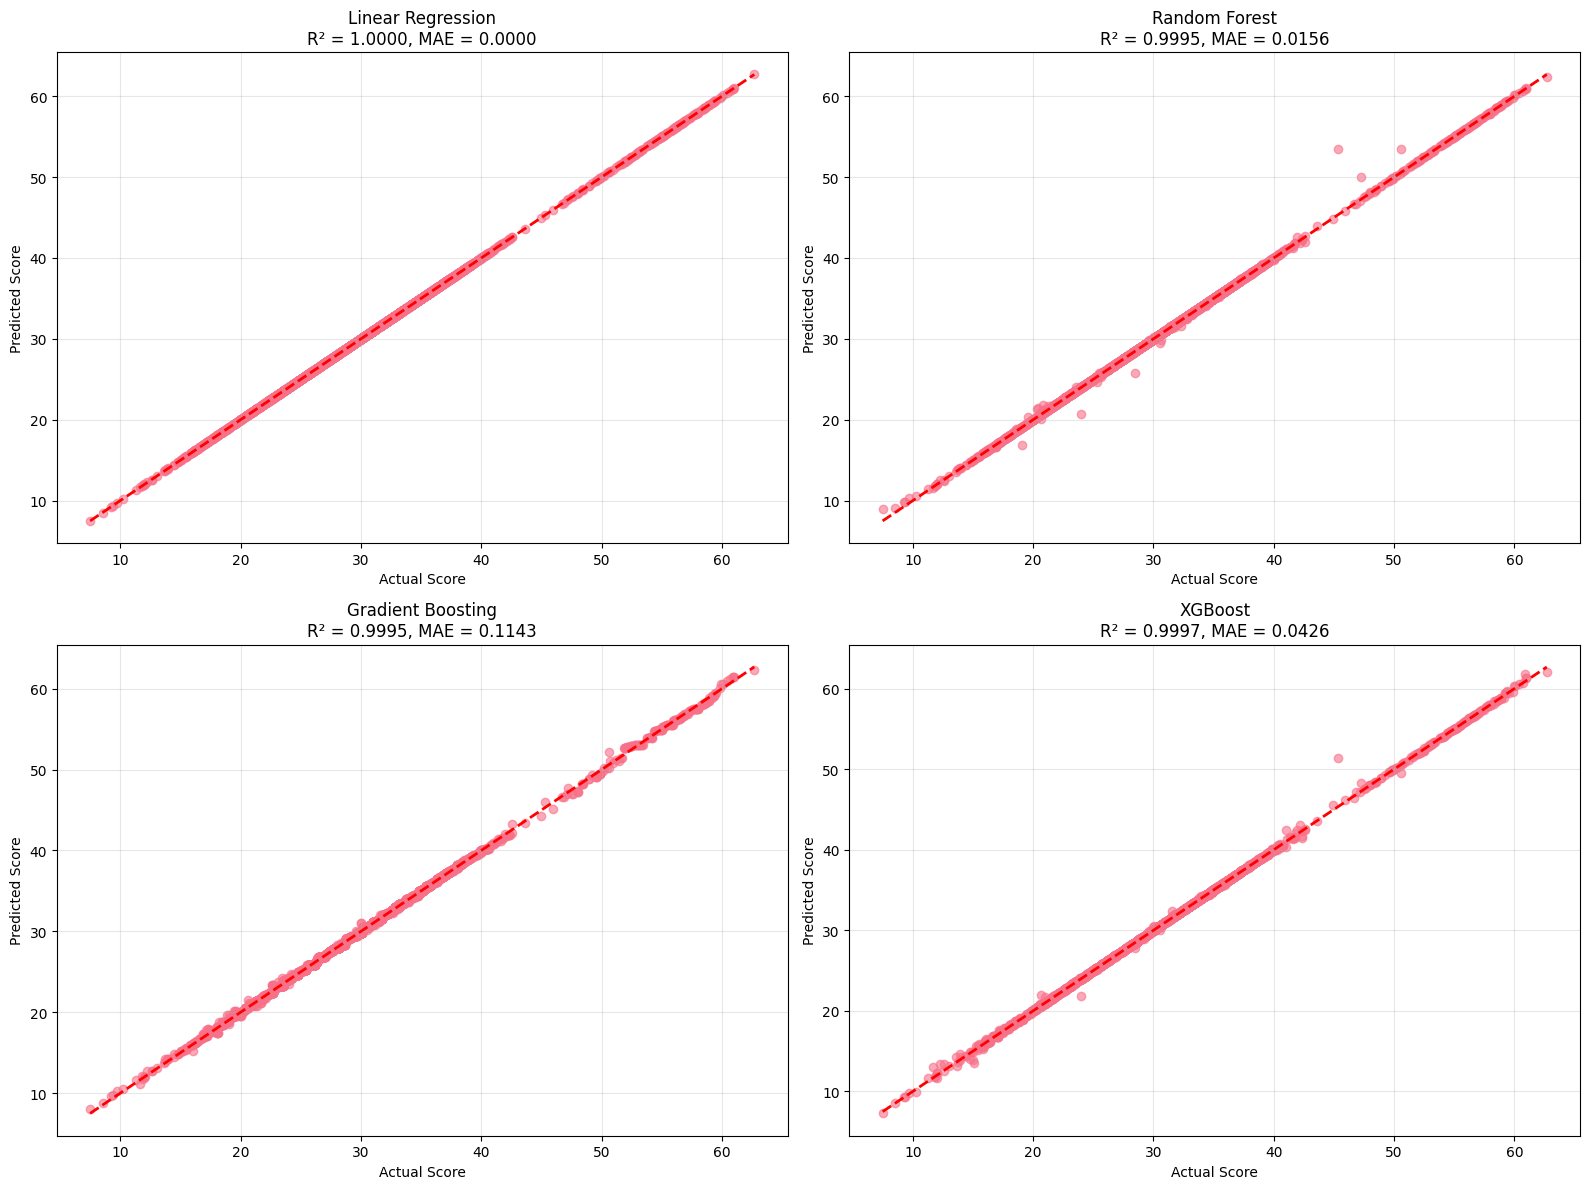


Feature Importance Analysis:

Random Forest - Top 10 Features:
               feature  importance
transformer_similarity    0.597202
        category_match    0.358784
     edu_match_present    0.040585
        skill_coverage    0.001609
     skill_match_ratio    0.001556
     skill_match_count    0.000181
          length_ratio    0.000046
      tfidf_similarity    0.000018
             jd_length    0.000008
   word2vec_similarity    0.000005

Gradient Boosting - Top 10 Features:
               feature   importance
transformer_similarity 6.286184e-01
        category_match 3.271355e-01
     edu_match_present 4.069854e-02
        skill_coverage 2.367267e-03
     skill_match_ratio 9.696832e-04
     skill_match_count 2.034284e-04
             jd_length 5.526606e-06
         resume_length 7.458644e-07
          length_ratio 6.808601e-07
      tfidf_similarity 2.752534e-07

XGBoost - Top 10 Features:
               feature  importance
        category_match    0.746053
transformer_similar

In [57]:
# Create comparison visualization
fig, axes = plt.subplots(2, 2, figsize=(16, 12))
axes = axes.flatten()

for i, (name, results) in enumerate(model_results.items()):
    ax = axes[i]
    
    # Scatter plot of actual vs predicted
    ax.scatter(y_test, results['predictions'], alpha=0.6)
    ax.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
    ax.set_xlabel('Actual Score')
    ax.set_ylabel('Predicted Score')
    ax.set_title(f'{name}\nR¬≤ = {results["r2"]:.4f}, MAE = {results["mae"]:.4f}')
    ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Feature importance analysis for tree-based models
print("\nFeature Importance Analysis:")

for name, results in model_results.items():
    if hasattr(results['model'], 'feature_importances_'):
        print(f"\n{name} - Top 10 Features:")
        
        importance_df = pd.DataFrame({
            'feature': X.columns,
            'importance': results['model'].feature_importances_
        }).sort_values('importance', ascending=False)
        
        print(importance_df.head(10).to_string(index=False))

Talent scoring system

In [58]:
class TalentScoringSystem:
    
    def __init__(self, best_model, scaler, feature_engineer, parser):
        self.model = best_model
        self.scaler = scaler
        self.feature_engineer = feature_engineer
        self.parser = parser
        
    # Score a specific resume-JD pair
    def score_resume_jd_pair(self, resume_idx, jd_idx, resume_df, jd_df, similarity_matrices):
        
        # Create features
        features = self.feature_engineer.create_comprehensive_features(
            resume_idx, jd_idx, resume_df, jd_df, similarity_matrices
        )
        
        # Convert to DataFrame
        feature_df = pd.DataFrame([features])
        
        # Scale if needed
        if hasattr(self.model, 'predict'):
            if isinstance(self.model, LinearRegression):
                feature_scaled = self.scaler.transform(feature_df)
                score = self.model.predict(feature_scaled)[0]
            else:
                score = self.model.predict(feature_df)[0]
        else:
            score = 0.0
        
        # Ensure score is in 0-100 range
        score = max(0, min(100, score))
        
        return {
            'score': score,
            'features': features,
            'resume_idx': resume_idx,
            'jd_idx': jd_idx
        }
    
    # Find top K candidates for a job description
    def find_top_candidates(self, jd_idx, resume_df, jd_df, similarity_matrices, top_k=5):
        
        scores = []
        for resume_idx in range(len(resume_df)):
            result = self.score_resume_jd_pair(
                resume_idx, jd_idx, resume_df, jd_df, similarity_matrices
            )
            scores.append(result)
        
        # Sort by score
        scores.sort(key=lambda x: x['score'], reverse=True)
        
        return scores[:top_k]

    # Find top K jobs for a resume    
    def find_top_jobs(self, resume_idx, resume_df, jd_df, similarity_matrices, top_k=5):
        
        scores = []
        for jd_idx in range(len(jd_df)):
            result = self.score_resume_jd_pair(
                resume_idx, jd_idx, resume_df, jd_df, similarity_matrices
            )
            scores.append(result)
        
        # Sort by score
        scores.sort(key=lambda x: x['score'], reverse=True)
        
        return scores[:top_k]

Initialize Best Model and Demonstrate System

In [63]:
# Select best model based on R¬≤ score
best_model_name = max(model_results.keys(), key=lambda x: model_results[x]['r2'])
best_model = model_results[best_model_name]['model']

print(f"\nBest performing model: {best_model_name}")
print(f"R¬≤ Score: {model_results[best_model_name]['r2']:.4f}")

# Initialize talent scoring system
talent_scorer = TalentScoringSystem(
    best_model, scaler, feature_engineer, parser
)

# Example 1: Find top candidates for a specific job
jd_idx = 0
print(f"\nExample 1: Top 5 candidates for job '{jd_df.iloc[jd_idx]['position_title']}' at {jd_df.iloc[jd_idx]['company_name']}")

top_candidates = talent_scorer.find_top_candidates(
    jd_idx, resume_df[:50], jd_df, similarity_matrices, top_k=5
)

for i, candidate in enumerate(top_candidates, 1):
    resume_idx = candidate['resume_idx']
    score = candidate['score']
    features = candidate['features']
    
    print(f"\nRank {i}: Resume {resume_idx} (Category: {resume_df.iloc[resume_idx]['Category']})")
    print(f"Score: {score:.2f}/100")
    print(f"Skill Match Ratio: {features['skill_match_ratio']:.2f}")
    print(f"Transformer Similarity: {features['transformer_similarity']:.4f}")
    print(f"Category Match: {'Yes' if features['category_match'] else 'No'}")

# Example 2: Find top jobs for a specific resume
resume_idx = 0
print(f"\n\nExample 2: Top 5 jobs for resume {resume_idx} (Category: {resume_df.iloc[resume_idx]['Category']})")

top_jobs = talent_scorer.find_top_jobs(
    resume_idx, resume_df, jd_df[:50], similarity_matrices, top_k=5
)

for i, job in enumerate(top_jobs, 1):
    jd_idx = job['jd_idx']
    score = job['score']
    features = job['features']
    
    print(f"\nRank {i}: {jd_df.iloc[jd_idx]['position_title']} at {jd_df.iloc[jd_idx]['company_name']}")
    print(f"Score: {score:.2f}/100")
    print(f"Skill Match Ratio: {features['skill_match_ratio']:.2f}")
    print(f"Transformer Similarity: {features['transformer_similarity']:.4f}")
    print(f"Category Match: {'Yes' if features['category_match'] else 'No'}")


Best performing model: Linear Regression
R¬≤ Score: 1.0000

Example 1: Top 5 candidates for job 'Sales Specialist' at Google

Rank 1: Resume 21 (Category: HR)
Score: 39.80/100
Skill Match Ratio: 0.00
Transformer Similarity: 0.7451
Category Match: No

Rank 2: Resume 38 (Category: HR)
Score: 38.25/100
Skill Match Ratio: 0.00
Transformer Similarity: 0.7063
Category Match: No

Rank 3: Resume 16 (Category: HR)
Score: 37.79/100
Skill Match Ratio: 0.00
Transformer Similarity: 0.6947
Category Match: No

Rank 4: Resume 12 (Category: HR)
Score: 37.70/100
Skill Match Ratio: 0.00
Transformer Similarity: 0.6924
Category Match: No

Rank 5: Resume 47 (Category: HR)
Score: 37.00/100
Skill Match Ratio: 0.00
Transformer Similarity: 0.6751
Category Match: No


Example 2: Top 5 jobs for resume 0 (Category: HR)

Rank 1: Senior Marketing Specialist at OhioHealth
Score: 39.07/100
Skill Match Ratio: 0.00
Transformer Similarity: 0.7269
Category Match: No

Rank 2: Chief Executive Officer at Ohio ENT & Allergy 

Performance Evaluation Metrics

In [64]:
# Calculate Precision@K for top candidates
def calculate_precision_at_k(scorer, jd_indices, resume_df, jd_df, similarity_matrices, k=5): 
    
    precisions = []
    
    for jd_idx in jd_indices:
        # Get ground truth: resumes with matching category
        jd_position = jd_df.iloc[jd_idx]['position_title'].lower()
        
        # Simple ground truth: resumes whose category appears in job title
        relevant_resumes = []
        for resume_idx in range(len(resume_df)):
            resume_category = resume_df.iloc[resume_idx]['Category'].lower()
            if any(word in jd_position for word in resume_category.split()):
                relevant_resumes.append(resume_idx)
        
        if not relevant_resumes:
            continue
            
        # Get top K predictions
        top_candidates = scorer.find_top_candidates(
            jd_idx, resume_df, jd_df, similarity_matrices, top_k=k
        )
        
        # Calculate precision
        predicted_relevant = [c['resume_idx'] for c in top_candidates]
        precision = len(set(predicted_relevant) & set(relevant_resumes)) / k
        precisions.append(precision)
    
    return np.mean(precisions) if precisions else 0.0

# Calculate precision for a sample of jobs
sample_jd_indices = list(range(min(20, len(jd_df))))
precision_5 = calculate_precision_at_k(
    talent_scorer, sample_jd_indices, resume_df[:100], jd_df, similarity_matrices, k=5
)

print(f"\nPrecision@5: {precision_5:.4f}")

# Model comparison summary
print(f"\nModel Performance Summary:")
print(f"{'Model':<20} {'R¬≤':<10} {'MAE':<10} {'MSE':<10}")
print("-" * 50)
for name, results in model_results.items():
    print(f"{name:<20} {results['r2']:<10.4f} {results['mae']:<10.4f} {results['mse']:<10.4f}")



Precision@5: 0.0000

Model Performance Summary:
Model                R¬≤         MAE        MSE       
--------------------------------------------------
Linear Regression    1.0000     0.0000     0.0000    
Random Forest        0.9995     0.0156     0.0300    
Gradient Boosting    0.9995     0.1143     0.0263    
XGBoost              0.9997     0.0426     0.0194    


In [66]:
# Save the complete talent scoring system
def save_talent_scoring_system():
    """Save all components of the talent scoring system"""
    
    # Save feature engineering components
    joblib.dump(feature_engineer, 'talent_feature_engineer.pkl')
    joblib.dump(parser, 'model_response_parser.pkl')
    joblib.dump(scaler, 'talent_scaler.pkl')
    
    # Save models
    for name, results in model_results.items():
        filename = f'talent_model_{name.lower().replace(" ", "_")}.pkl'
        joblib.dump(results['model'], filename)
    
    # Save best model specifically
    joblib.dump(best_model, 'best_talent_model.pkl')
    
    # Save feature dataset
    feature_df.to_csv('talent_feature_dataset.csv', index=False)
    
    # Save evaluation results
    evaluation_results = {
        'model_performance': {name: {k: v for k, v in results.items() if k != 'model'} 
                             for name, results in model_results.items()},
        'best_model': best_model_name,
        'precision_at_5': precision_5,
        'feature_importance': {}
    }
    
    # Add feature importance for tree-based models
    for name, results in model_results.items():
        if hasattr(results['model'], 'feature_importances_'):
            evaluation_results['feature_importance'][name] = {
                'features': list(X.columns),
                'importance': results['model'].feature_importances_.tolist()
            }
    
    with open('talent_evaluation_results.json', 'w') as f:
        json.dump(evaluation_results, f, indent=2)
    
    print("\nTalent scoring system saved successfully!")

save_talent_scoring_system()

TypeError: Object of type ndarray is not JSON serializable